# GLM

By Charles Xu @ DJA Lab, Caltech

## Set up

### Packages and functions

In [96]:
# Import packages
# import sys
# if '/Users/alveus/Documents/WorkingDirectory/Packages/Python' not in sys.path:
#     sys.path.insert(0, '/Users/alveus/Documents/WorkingDirectory/Packages/Python')

import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import scipy.io as sio

import statsmodels.api as sm

from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import PCA

# System
import sys

# import ssm
# from ssm.util import find_permutation

In [97]:
# Define helper functions
# Define function to make the design matrix
def make_design_matrix(input_raw, time_window, frame_rate, time_step):
    """
    input_raw: ndarray of shape (num_variables, num_samples)
        Input data
    time_window: int
        Time window for design matrix (plus or minus) (in seconds)
    frame_rate: int
        Frame rate of the data (in Hz)
    time_step: int
        Time step for the regressors (in frames)
    """
    num_rows = input_raw.shape[0]
    num_shifts = int(time_window * frame_rate // time_step)
    design_matrix = np.zeros((num_rows*(2*num_shifts+1), input_raw.shape[1]))

    for i in range(num_rows):
        for j in range(-time_window*frame_rate, time_window*frame_rate+1, time_step):
            if j == 0:
                design_matrix[i*(num_shifts*2+1)+j//time_step+num_shifts, :] = input_raw[i,:]
            elif j < 0:
                design_matrix[i*(num_shifts*2+1)+j//time_step+num_shifts, :j] = input_raw[i,-j:]
            else:
                design_matrix[i*(num_shifts*2+1)+j//time_step+num_shifts, j:] = input_raw[i,:-j]
    return design_matrix.T

# Define function to plot R-squared values
def plot_r2(r2, yd, color='r'):
    """
    r2: ndarray
        1D array of R-squared values for each neuron
    yd: int
        Number of neurons
    color: str
        Color of the plot
    """
    idx = np.argsort(r2)[::-1]

    fig, ax = plt.subplots()
    ax.plot(r2[idx], color = color)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, yd])
    ax.set_ylim([0,max(r2)])
    ax.set_xlabel('Neurons', fontsize=14)
    ax.set_ylabel('cross-validated R\u00b2', fontsize=14)

    # Print best R-squared and best fit neuron
    best_r2 = max(r2)
    best_fit_neuronidx = np.argmax(r2)
    
    print(f'Best R\u00b2: {best_r2}')
    print(f'Best fit neuron: {best_fit_neuronidx+1}')
    return ax, best_fit_neuronidx

# Define function to plot beta weights for each input variable
def plot_inputvar_betas(betas_reshaped, neuron_id, labels, time_step, color='b'):
    '''
    betas_reshaped: ndarray
        3D array of betas (neuron x behavior x regressor)
    neuron_id: int
        Neuron ID
    labels: list
        List of labels for each input variable
    time_step: int
        Time step for the regressors (in frames)
    color: str
        Color of the plot
    '''
    neuron_idx = neuron_id - 1
    num_labels = len(labels)

    fig, axs = plt.subplots(nrows=np.ceil(num_labels/2).astype(int), ncols=2, figsize=(10, 4*num_labels//2), constrained_layout=True)

    for i in range(num_labels):
        row = i // 2
        col = i % 2
        axs[row, col].plot(np.arange(-(betas_reshaped.shape[2] // 2), betas_reshaped.shape[2] // 2 + 1) * time_step, betas_reshaped[neuron_idx, i, :].T, color=color)
        axs[row, col].hlines(0, -(betas_reshaped.shape[2] // 2) * time_step, (betas_reshaped.shape[2] // 2) * time_step, color='k', linestyle='--')
        axs[row, col].set_xticks(np.arange(-(betas_reshaped.shape[2] // 2), betas_reshaped.shape[2] // 2 + 1, time_step) * time_step)
        axs[row, col].set_xticklabels(np.arange(-(betas_reshaped.shape[2] // 2), betas_reshaped.shape[2] // 2 + 1, time_step) * time_step // frame_rate)
        axs[row, col].set_ylim([np.amin(betas_reshaped[neuron_idx, :, :]), np.amax(betas_reshaped[neuron_idx, :, :])])
        axs[row, col].set_title(labels[i])
        axs[row, col].set_xlabel('Time (s)')
        axs[row, col].set_ylabel('Beta weight')

        if i == num_labels - 1 and num_labels % 2 == 1:
            axs[row, col+1].axis('off')

    fig.suptitle(f'Beta weights for neuron {neuron_id}')
    return fig, axs

# Define function to plot model prediction vs actual data
def plot_model_prediction(betas_all, x, y, neuron_idx, r2, color='r'):
    '''
    betas_all: ndarray
        2D array of betas (neuron x regressor)
    x: ndarray
        2D array of input data (time x regressor)
    y: ndarray
        2D array of output data (time x neuron)
    neuron_idx: int
        Neuron ID
    r2: ndarray
        1D array of R-squared values for each neuron
    color: str
        Color of the plot
    '''
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(y[:,neuron_idx], color='k', label='True') # Plot true data

    # Manually calculate ridge regression prediction
    betas = betas_all[neuron_idx, :]
    y_pred = np.zeros_like(y[:,neuron_idx])
    for i in range(x.shape[1]):
        y_pred += betas[i] * x[:,i]
    ax.plot(y_pred, color=color, label=f'Predicted (R\u00b2={round(r2[neuron_idx], 2)})')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, y.shape[0]])
    ax.set_xlabel('Time')
    ax.set_ylabel('Neural activity')
    ax.set_title(f'Prediction for neuron {neuron_idx+1}')
    ax.legend()

    return fig, ax

# Define function to perform k-means with silhouette analysis
def plot_kmeans_silhouette(range_n_clusters, data):
    """
    range_n_clusters: list
        List of number of clusters to perform k-means with silhouette analysis on
    data: ndarray
        2D array of data (samples x features)
    """
    num_clusters = len(range_n_clusters)
    silhouette_scores = []
    fig, axs = plt.subplots(nrows=num_clusters, ncols=2, figsize=(10, 4*num_clusters), constrained_layout=True)
    for i in range(num_clusters):
        n_clusters = range_n_clusters[i]
        axs[i, 0].set_xlim([-0.1, 1])
        axs[i, 0].set_ylim([0, yd + (n_clusters + 1) * 10])

        # Fit the KMeans model and calculate silhouette scores
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
        cluster_labels = kmeans.labels_
        silhouette_score_value = silhouette_score(data, cluster_labels)
        print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_score_value)
        silhouette_scores.append(silhouette_score_value)
        silhouetee_samples = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for n in range(n_clusters):
            nth_cluster_silhouette_values = silhouetee_samples[cluster_labels == n] # Aggregate the silhouette scores for samples belonging to cluster n
            nth_cluster_silhouette_values.sort() # Sort the silhouette scores

            nth_cluster_size = nth_cluster_silhouette_values.shape[0] # Get the size of cluster n
            y_upper = y_lower + nth_cluster_size # Set the position of the silhouette plot for cluster n
            color = cm.nipy_spectral(float(n) / n_clusters)
            axs[i, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, nth_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
            axs[i, 0].text(-0.05, y_lower + 0.5 * nth_cluster_size, str(n)) # Label the silhouette plots with their cluster numbers at the middle

            y_lower = y_upper + 10

        axs[i, 0].set_title("Silhouette plot for the various clusters (n_clusters = %d)" % n_clusters)
        axs[i, 0].set_xlabel("Silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_score_value, color="red", linestyle="--")
        axs[i, 0].set_yticks([])  # Clear the yaxis labels / ticks
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # Plot the cluster
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)

        if data.shape[1] == 2:
            axs[i, 1].scatter(data[:, 0], data[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = kmeans.cluster_centers_
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("Visualization of the clustered data (n_clusters = %d)" % n_clusters)
            axs[i, 1].set_xlabel("1st feature in feature space")
            axs[i, 1].set_ylabel("2nd feature in feature space")

        else:
            pca = PCA(n_components=2).fit(data)
            data_pca = pca.transform(data)
            axs[i, 1].scatter(data_pca[:, 0], data_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")
            cluster_centers = pca.transform(kmeans.cluster_centers_)
            axs[i, 1].scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k")

            for j, c in enumerate(cluster_centers):
                axs[i, 1].scatter(c[0], c[1], marker="$%d$" % j, alpha=1, s=50, edgecolor="k")

            axs[i, 1].set_title("The visualization of the clustered data.")
            axs[i, 1].set_xlabel("PC1 in PCA mapping of feature space")
            axs[i, 1].set_ylabel("PC2 in PCA mapping of feature space")

        plt.suptitle(
            "k-means clustering with Sillhouette analysis",
            fontsize=14,
            fontweight="bold",
        )

    print("The number of clusters that maximizes silhouette score is: ", range_n_clusters[np.argmax(silhouette_scores)])
    return fig, axs, range_n_clusters[np.argmax(silhouette_scores)]

# Define function to plot tuning of beta weights
def plot_tuning_beta(n_clusters, data, neuron_idx=None):
    """
    n_clusters: int
        Number of clusters
    data: ndarray
        2D array of data (samples x features)
    neuron_idx: ndarray
        1D array of neuron IDs
    """
    # Fit k-means clustering with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(data)
    cluster_labels = kmeans.labels_

    # Group neurons by cluster
    data_reordered = np.zeros_like(data)
    sample_ids = np.zeros_like(cluster_labels)
    n_ith_cluster_lower = 0
    n_ith_cluster_upper = 0
    for i in range(n_clusters):
        n_ith_cluster_upper = n_ith_cluster_lower + sum(cluster_labels == i)
        data_reordered[n_ith_cluster_lower:n_ith_cluster_upper, :] = data[cluster_labels == i, :]
        if neuron_idx is None:
            sample_ids[n_ith_cluster_lower:n_ith_cluster_upper] = np.where(cluster_labels == i)[0] + 1
        else:
            sample_ids[n_ith_cluster_lower:n_ith_cluster_upper] = neuron_idx[np.where(cluster_labels == i)] + 1
        n_ith_cluster_lower = n_ith_cluster_upper

    # Determine the color scale based on the min and max of both datasets
    vmin = np.min(data_reordered)
    vmax = np.max(data_reordered)
    if vmin < 0 and vmax > 0:
        divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
    elif vmin >= 0:
        coolwarm = cm.get_cmap('coolwarm')
        warm_colors = coolwarm(np.linspace(0.5, 1, 256)) # Get warm colors
        warm = mcolors.LinearSegmentedColormap.from_list('warm', warm_colors) # Create warm colormap
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    
    # Plot a heat map of beta values
    fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
    if vmin < 0 and vmax > 0:
        im = ax.imshow(data_reordered.T, cmap='coolwarm', norm=divnorm, aspect='auto')
    elif vmin >= 0:
        im = ax.imshow(data_reordered.T, cmap=warm, norm=norm, aspect='auto')
    ax.set_xlim([-1/2, data.shape[0] - 1/2])
    ax.set_xticks(np.arange(data.shape[0]))
    ax.set_xticklabels(sample_ids, rotation=90)
    ax.set_yticks(np.arange(data.shape[1]))
    ax.set_yticklabels(labels, fontsize=12)
    cbar = ax.figure.colorbar(im, ax=ax) # Colorbar
    cbar.ax.set_ylabel('Beta weights', fontsize=14, rotation=-90, va="bottom")

    # Separate clusters
    for i in range(1, n_clusters):
        ax.axvline(x=np.sum(cluster_labels < i) - 1/2, color='black', linestyle='--')

    ax.set_xlabel('Neurons', fontsize=14)
    ax.set_ylabel('Input labels', fontsize=14)
    ax.set_title('Tuning of beta weights', fontsize=16)
    
    return fig, ax

# Define function to plot neural activity traces with input labels
def plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot, *optional_colors):
    """
    y: normalized neural data
    input_labeled: labeled input data
    neuron_id: neuron number
    labels_to_plot: list of labels to plot
    *optional_colors: 2-dimensional array, optional list of colors for each label
    """
    neuron_idx = neuron_id - 1
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(y[:,neuron_idx], color='k', label='neuron %d' % neuron_id) # Plot neural activity
    ax.set_xticks(np.arange(0, y.shape[0], 2000))
    ax.set_xticklabels(np.arange(0, y.shape[0], 2000) // frame_rate)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0, y.shape[0]])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Neural activity')
    ax.set_title(f'Neural activity (z-score) for neuron {neuron_id}')

    # Plot input labels as colored boxes
    colors = cm.rainbow_r((np.arange(len(labels_to_plot))+1)/(len(labels_to_plot)+1))
    if optional_colors:
        colors = np.concatenate((optional_colors[0], colors))
    handles, labels = ax.get_legend_handles_labels()
    handles_display = [handles[-1]]
    labels_display = [labels[-1]]
    for l in range(len(labels_to_plot)):
        label = labels_to_plot[l]
        if np.sum(input_labeled[label]) == 0:
            continue
        first = True
        for i in range(tt):
            if input_labeled[label][i] == 1 and first:
                ax.fill_between([i, i+1], y[:,neuron_idx].min(), y[:,neuron_idx].max(), color=colors[l], alpha=0.3, label=label)
                handles, labels = ax.get_legend_handles_labels()
                handles_display.append(handles[-1])
                labels_display.append(labels[-1])
                first = False
            if input_labeled[label][i] == 1:
                ax.fill_between([i, i+1], y[:,neuron_idx].min(), y[:,neuron_idx].max(), color=colors[l], alpha=0.3, label='_nolegend_')

    ax.legend(handles_display, labels_display)

    return fig, ax

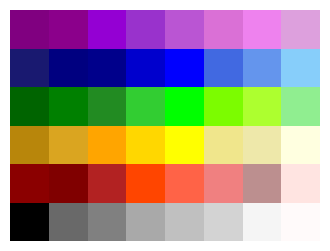

In [98]:
# Define colors
blacks = ['black', 'dimgrey', 'grey', 'darkgrey', 'silver', 'lightgrey', 'whitesmoke', 'snow']
reds = ['darkred', 'maroon', 'firebrick', 'orangered', 'tomato', 'lightcoral', 'rosybrown', 'mistyrose']
yellows = ['darkgoldenrod', 'goldenrod', 'orange', 'gold', 'yellow', 'khaki', 'palegoldenrod', 'lightyellow']
greens = ['darkgreen', 'green', 'forestgreen', 'limegreen', 'lime', 'lawngreen', 'greenyellow', 'lightgreen']
blues = ['midnightblue', 'navy', 'darkblue', 'mediumblue', 'blue', 'royalblue', 'cornflowerblue', 'lightskyblue']
purples = ['purple', 'darkmagenta', 'darkviolet', 'darkorchid', 'mediumorchid', 'orchid', 'violet', 'plum']

color_groups = [blacks, reds, yellows, greens, blues, purples]

fig, ax = plt.subplots(1, 1, figsize=(4, len(color_groups)//2))

for sp in ax.spines.values():
    sp.set_visible(False)

ax.set_xticks([])
ax.set_yticks([])

for i, color_group in enumerate(color_groups):
    for j, color in enumerate(color_group):
        rect = patches.Rectangle((j, i), 1, 1, facecolor=color)
        ax.add_patch(rect)

ax.set_xlim(0, max(len(group) for group in color_groups))
ax.set_ylim(0, len(color_groups))

plt.show()

### Load data

In [99]:
# User inputs
datafile_M1 = r'data/M1_fasted_unreg_preprocessed.mat'
datafile_M2 = r'data/M2_fasted_unreg_male1_preprocessed.mat'
# datafile_M1 = r'data/EG1-1_fasted_unreg_preprocessed_use.mat'
# datafile_M2 = r'data/EG1-4_fasted_unreg_male1_preprocessed_use.mat'
mouse = 'M1' # 'M1' or 'M2'

In [100]:
# GLM parameters
frame_rate = 10 # Frame rate of the data (in Hz)
time_window = 5 # Time window for regressors (in seconds)
time_step = 5 # Time step for the regressors (in frames)
n_folds = 5 # Number of folds for cross-validation
good_beta_threshold = 0.5 # Threshold for good betas as a proportion of the maximum beta

In [101]:
if mouse == 'M1':
    mat = sio.loadmat(datafile_M1)
    input_raw = mat['behaviorDataPreprocessed'] # Behavior data
    output_raw = np.array(mat['neuralDataPreprocessed']) # Neural data
    labels_raw = mat['behaviorLabelsPreprocessed'] # Behavior labels
    stimuli = mat['stimuliDataPreprocessed'] # Stimuli
    stimuli_labels_raw = mat['stimuliLabelsPreprocessed'] # Stimuli labels
elif mouse == 'M2':
    mat = sio.loadmat(datafile_M2)
    input_raw = mat['behaviorDataPreprocessed'] # Behavior data
    output_raw = np.array(mat['neuralDataPreprocessed']) # Neural data
    labels_raw = mat['behaviorLabelsPreprocessed'] # Behavior labels
    stimuli = mat['stimuliDataPreprocessed'] # Stimuli
    stimuli_labels_raw = mat['stimuliLabelsPreprocessed'] # Stimuli labels
else:
    sys.exit('Invalid mouse selection!')

labels = [] # Behavior labels
for i in range(len(labels_raw)):
    labels.append(labels_raw[i][0][0])

stimuli_labels = [] # Stimuli labels
for i in range(len(stimuli_labels_raw)):
    stimuli_labels.append(stimuli_labels_raw[i][0][0])

print(f'Number of input variables: {input_raw.shape[0]}')
print(f'Length of session: {input_raw.shape[1]}')
print(f'The input variables are: {labels}')
print(f'Number of output variables: {output_raw.shape[0]}')
print(f'Number of stimuli variables: {stimuli.shape[0]}')
print(f'The stimuli variables are: {stimuli_labels}')


Number of input variables: 7
Length of session: 6392
The input variables are: ['baseline', 'introduction', 'sniffM', 'attack', 'food_approach', 'food_sniff', 'eating']
Number of output variables: 144
Number of stimuli variables: 3
The stimuli variables are: ['baseline', 'male', 'food']


## Processing data

### Process variables
Smoothing has been done in MATLAB using preprocessHangryMice.m

In [102]:
input_labeled = {label: input_raw[i] for i, label in enumerate(labels)} # Create dictionary of input variables with labels

In [103]:
# Select mixed selective neurons
if mouse == 'M1': # M1
    mixed_selective_neurons = [17, 19]
    output_mixed = output_raw[mixed_selective_neurons, :]
elif mouse == 'M2': # M2
    mixed_selective_neurons = [5, 26, 27, 30, 33, 55, 59, 70, 81, 86]
    output_mixed = output_raw[mixed_selective_neurons, :]

### Make design matrix

In [104]:
# Make the design matrix
x = make_design_matrix(input_raw, time_window, frame_rate, time_step)
y = output_mixed.T
xd = x.shape[1]
yd = y.shape[1]
tt = x.shape[0]
print(f'Features of x: {xd}')
print(f'Features of y: {yd}')
print(f'Total time points: {tt}')

Features of x: 147
Features of y: 2
Total time points: 6392


### Normalize data by z-score

In [105]:
# z-score the data
# x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
# y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)

## Fit GLMs

In [106]:
# Set up k-fold cross-validation
kf = KFold(n_splits=n_folds, shuffle=True, random_state=0) # Initialize KFold object, with deterministic output

### Fit using simple linear regression

In [107]:
# Fit linear regression model
linreg = linear_model.LinearRegression()

betas_lin = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_lin = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    linreg.fit(x_train, y_train) # Fit ridge regression model
    betas_lin[:,:,i] = linreg.coef_ # Store betas

    y_pred = linreg.predict(x_test) # Predict y
    r2_lin[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_lin = np.mean(betas_lin, axis=2) # Average betas across folds
r2_lin = np.mean(r2_lin, axis=1) # Average R2 across folds


### Fit using ridge regression which penalizes $\beta$ by $L_2$ regularization

#### Determine the best complexity parameter, $\alpha$, using grid search CV

In [108]:
# Set up grid search CV
alpha_test_range = 10**np.linspace(-10,9,50) # Get search values for alpha on log scale

fit_intercept = False # If y is mean-centered, set to False
alpha_per_target = True # Allow every neuron to be regularized individualy for better model performance

# Perform grid search CV using RidgeCV
ridge_grid_search = linear_model.RidgeCV(alphas=alpha_test_range, fit_intercept=fit_intercept, scoring='r2', store_cv_values=True, alpha_per_target=alpha_per_target)
ridge_grid_search.fit(x,y)
alphas = ridge_grid_search.alpha_

Text(0, 0.5, 'Count')

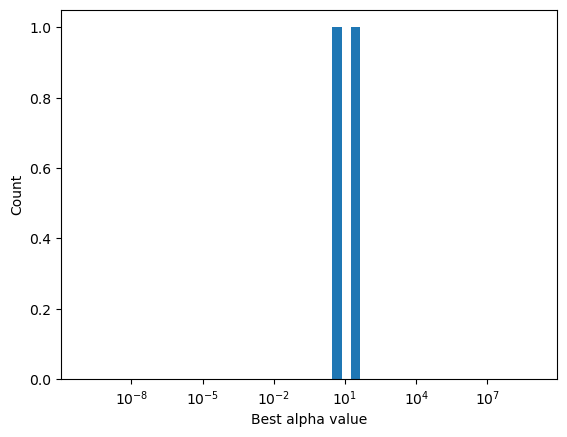

In [109]:
# Distribution of best alphas
fig,ax = plt.subplots()
ax.hist(alphas, bins=alpha_test_range)
ax.set_xscale('log')
ax.set_xlabel('Best alpha value')
ax.set_ylabel('Count')

#### Fit ridge regression

In [110]:
# Fit ridge regression model
ridgereg = linear_model.Ridge(alpha=alphas, fit_intercept=fit_intercept) # Initialize Ridge object

betas_ridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_ridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    ridgereg.fit(x_train, y_train) # Fit ridge regression model
    betas_ridge[:,:,i] = ridgereg.coef_ # Store betas

    y_pred = ridgereg.predict(x_test) # Predict y
    r2_ridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_ridge = np.mean(betas_ridge, axis=2) # Average betas across folds
r2_ridge = np.mean(r2_ridge, axis=1) # Average R2 across folds

#### Fit ridge regression with non-negativity constraint

Note that the non-negative ridge only allows for the lbfgs solver, which is an optimisation algorithm and does not reach a closed-form solution

In [111]:
# Fit ridge regression with non-negative constraints with lbfgs solver
nnridgereg = linear_model.Ridge(alpha=alphas, fit_intercept=fit_intercept, solver='lbfgs', positive=True) # Initialize Ridge object

betas_nnridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
r2_nnridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
    x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
    y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

    nnridgereg.fit(x_train, y_train) # Fit ElasticNet regression model
    betas_nnridge[:,:,i] = nnridgereg.coef_ # Store betas

    y_pred = nnridgereg.predict(x_test) # Predict y
    r2_nnridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

betas_nnridge = np.mean(betas_nnridge, axis=2) # Average betas across folds
r2_nnridge = np.mean(r2_nnridge, axis=1) # Average R2 across folds

### Fit using LASSO regression which penalizes $\beta$ by $L_1$ regularization

## Assess model performance

### Cross-validated R-squared score

Best R²: 0.7987761344557945
Best fit neuron: 2
Best R²: 0.7962299251026673
Best fit neuron: 2
Best R²: 0.4796096036997862
Best fit neuron: 1


Text(0.5, 1.0, 'Non-negative ridge regression performance')

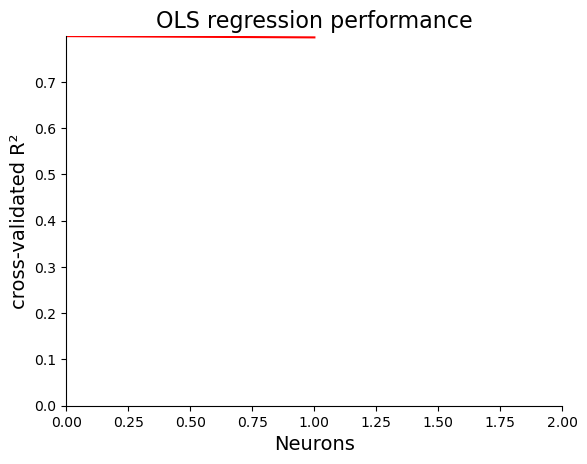

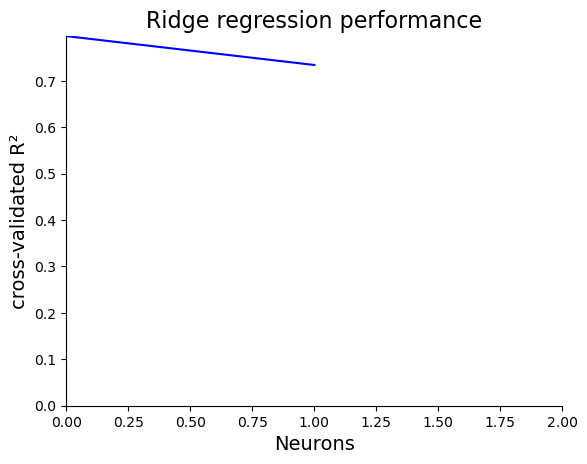

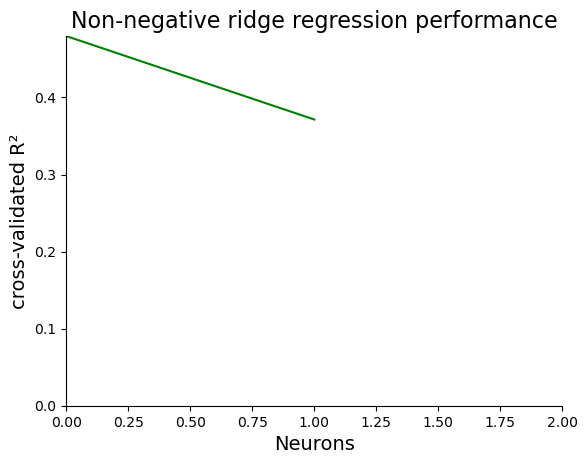

In [112]:
# Plot R-squared for each neuron using OLS
ax, best_fit_neuronidx_lin = plot_r2(r2_lin, yd)
ax.set_title('OLS regression performance', fontsize=16)

# Plot R-squared for each neuron using ridge regression
ax, best_fit_neuronidx_ridge = plot_r2(r2_ridge, yd, color='b')
ax.set_title('Ridge regression performance', fontsize=16)

# Plot R-squared for each neuron using non-negative ridge regression
ax, best_fit_neuronidx_nnridge = plot_r2(r2_nnridge, yd, color='g')
ax.set_title('Non-negative ridge regression performance', fontsize=16)

### Plot beta weights for each regressors

In [113]:
# Reshape betas to be 3D (neuron x behavior x regressor)
betas_lin_reshaped = betas_lin.reshape((yd, input_raw.shape[0], x.shape[1]//input_raw.shape[0]))
betas_ridge_reshaped = betas_ridge.reshape((yd, input_raw.shape[0], x.shape[1]//input_raw.shape[0]))
betas_nnridge_reshaped = betas_nnridge.reshape((yd, input_raw.shape[0], x.shape[1]//input_raw.shape[0]))

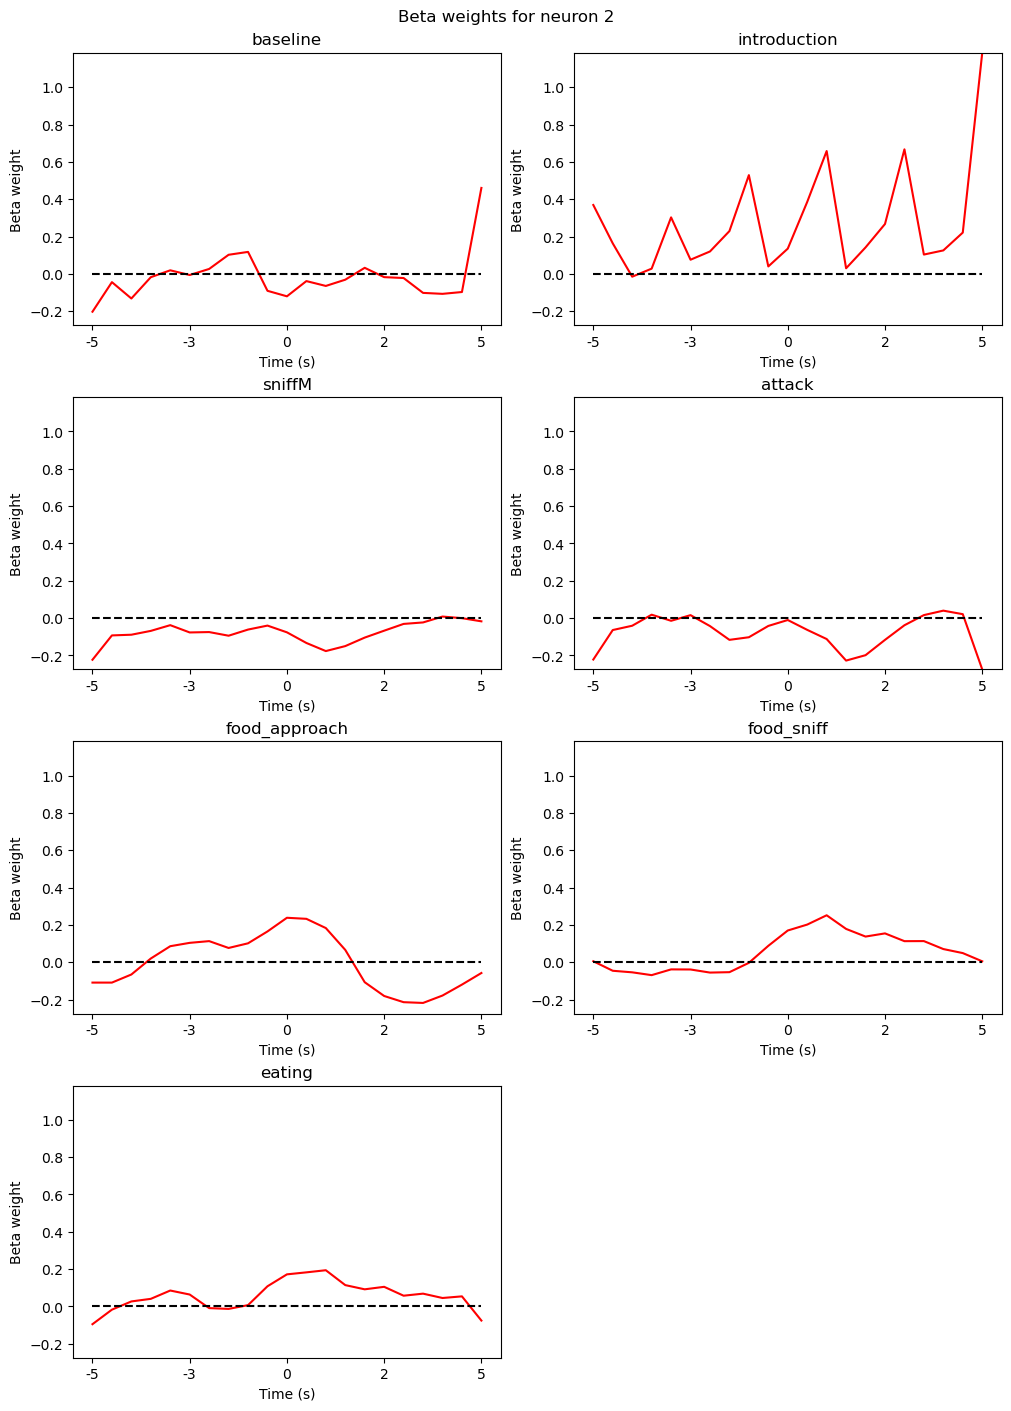

In [114]:
# Plot betas for each behavior using OLS (for best fit neuron using OLS)
fig, axs = plot_inputvar_betas(betas_lin_reshaped, best_fit_neuronidx_lin+1, labels, time_step, color='r')

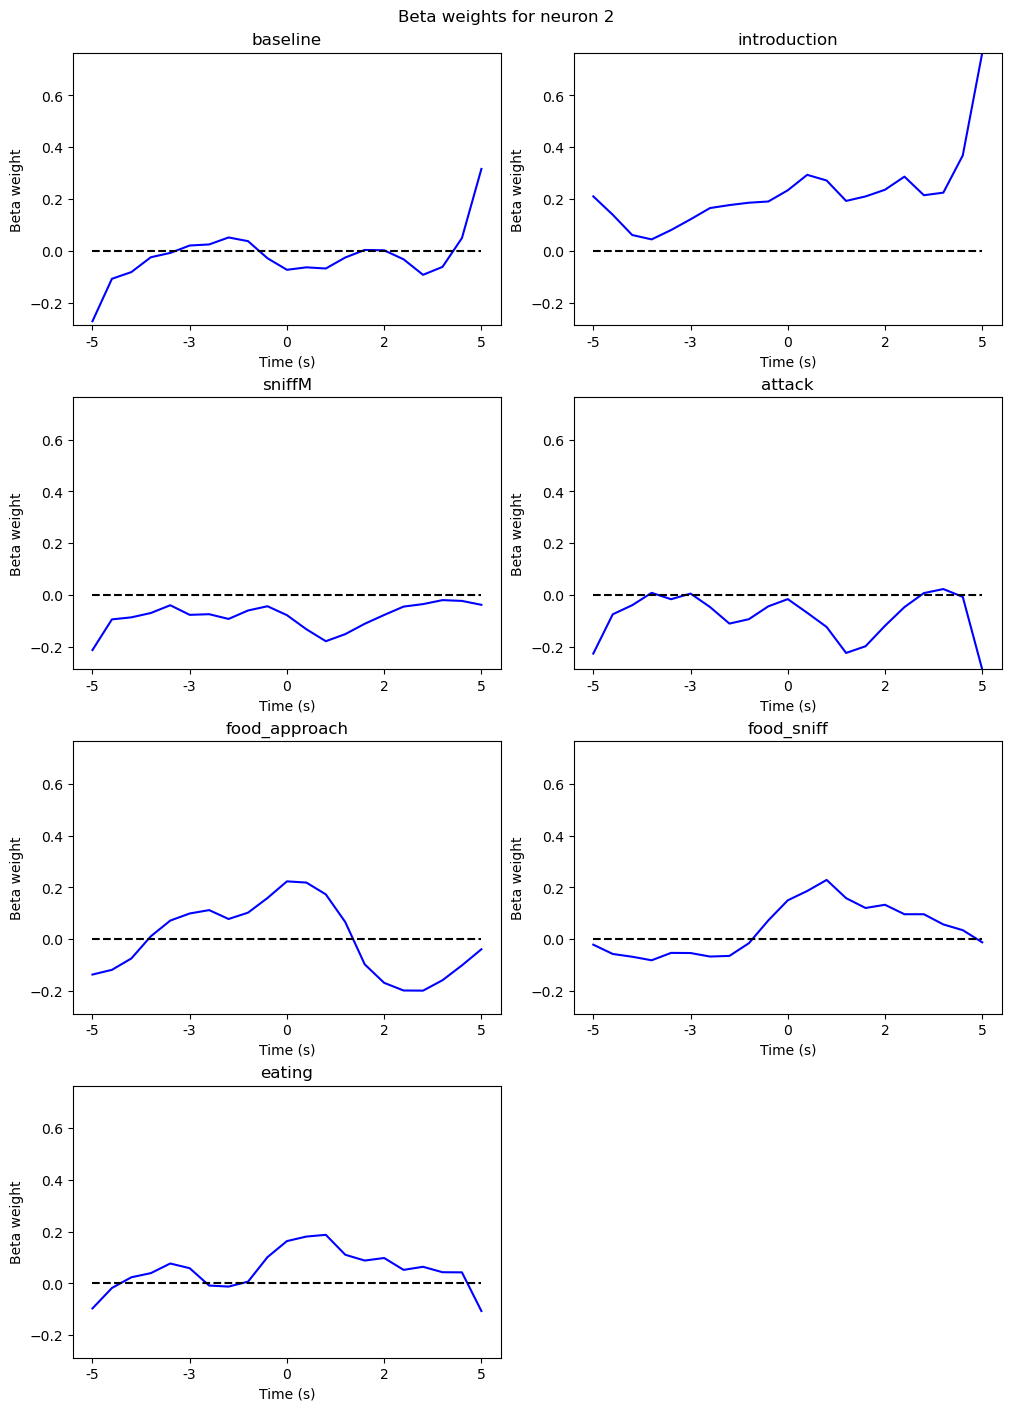

In [115]:
# Plot betas for each behavior using ridge regression (for best fit neuron using ridge regression)
fig, axs = plot_inputvar_betas(betas_ridge_reshaped, best_fit_neuronidx_ridge+1, labels, time_step, color='b')

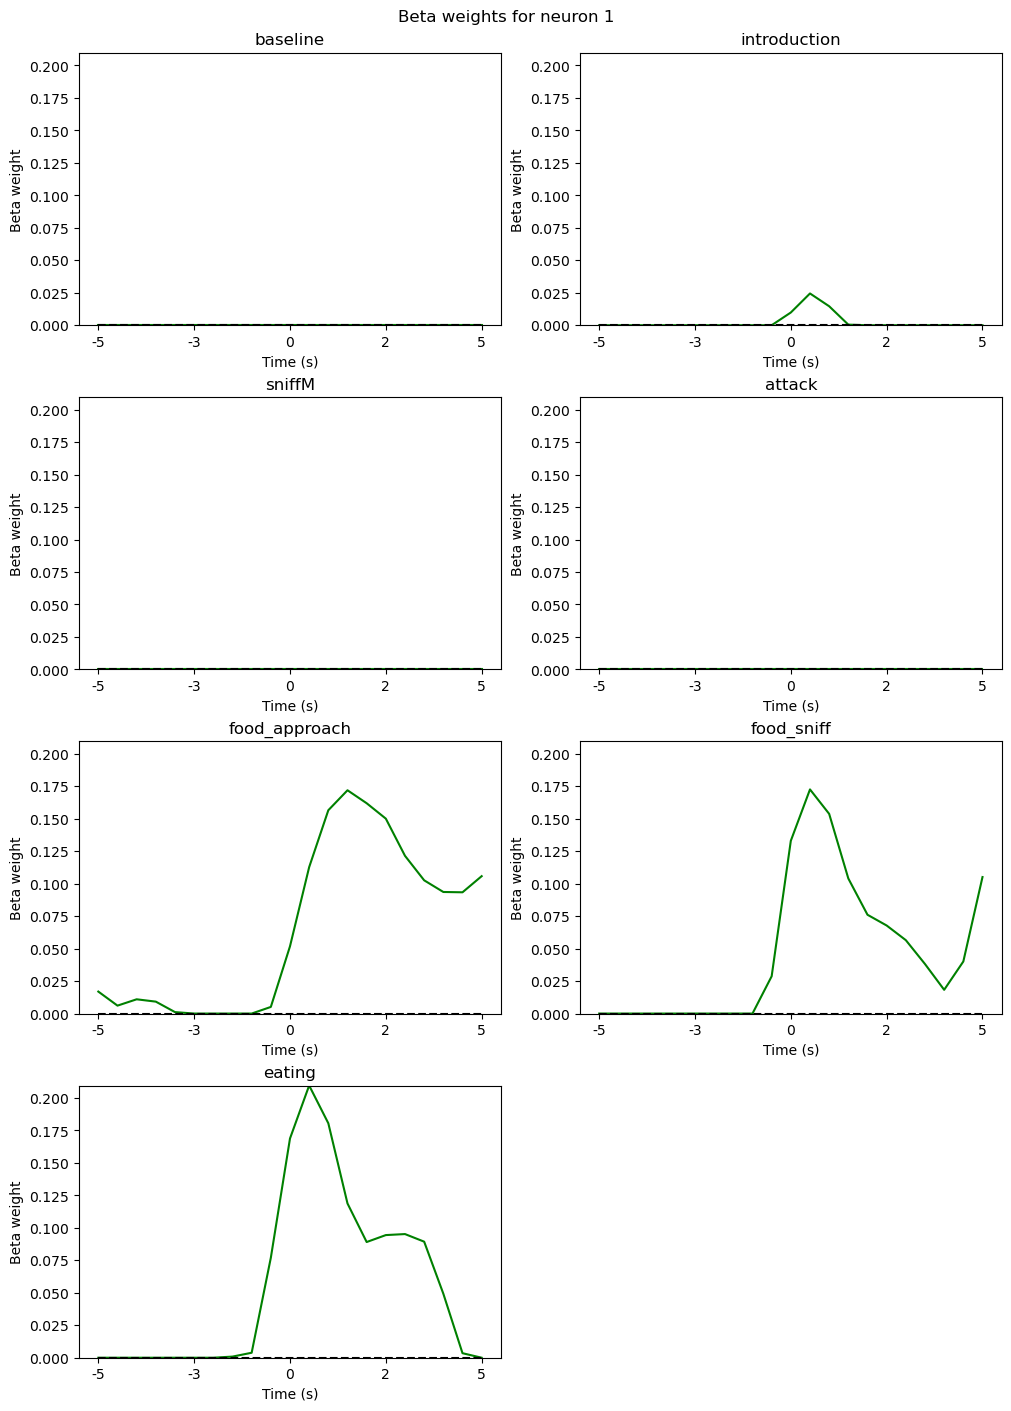

In [116]:
# Plot betas for each behavior using non-negative ridge regression (for best fit neuron using non-negative ridge regression)
fig, axs = plot_inputvar_betas(betas_nnridge_reshaped, best_fit_neuronidx_nnridge+1, labels, time_step, color='g')

### Select good fit neurons

In [117]:
# Select neurons with good fits (from OLS)
good_fit_neuron_lin = np.where(r2_lin > np.max(r2_lin)*good_beta_threshold)[0]
print(f'Number of neurons with good fits using OLS: {len(good_fit_neuron_lin)}')

# Select neurons with good fits (from ridge regression)
good_fit_neuron_ridge = np.where(r2_ridge > np.max(r2_ridge)*good_beta_threshold)[0]
print(f'Number of neurons with good fits using ridge regression: {len(good_fit_neuron_ridge)}')

# Select neurons with good fits (from non-negative ridge regression)
good_fit_neuron_nnridge = np.where(r2_nnridge > np.max(r2_nnridge)*good_beta_threshold)[0]
print(f'Number of neurons with good fits using non-negative ridge regression: {len(good_fit_neuron_nnridge)}')

# Show neurons with good fits
print(good_fit_neuron_lin+1, good_fit_neuron_ridge+1, good_fit_neuron_nnridge+1)

Number of neurons with good fits using OLS: 2
Number of neurons with good fits using ridge regression: 2
Number of neurons with good fits using non-negative ridge regression: 2
[1 2] [1 2] [1 2]


### Model prediction

Plot model prediction compared actual neural data

Text(0.5, 1.0, 'Prediction for best fit neuron (1) using non-negative ridge regression')

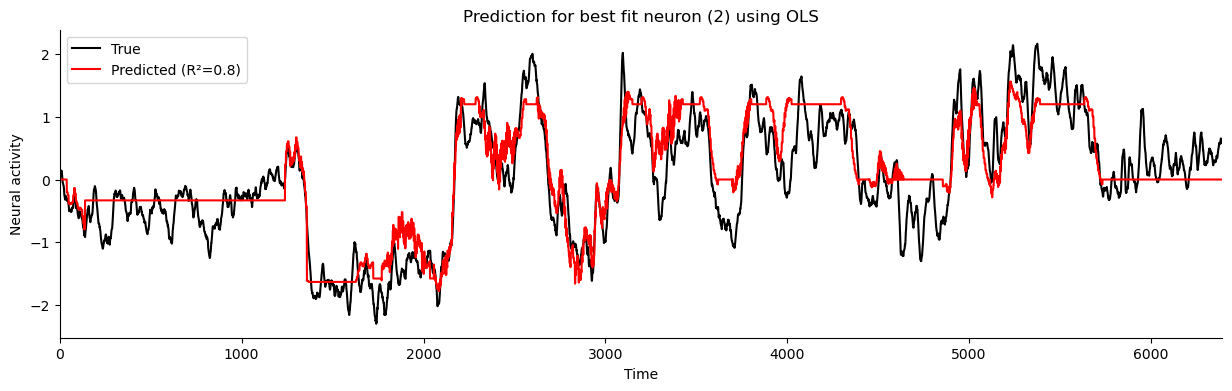

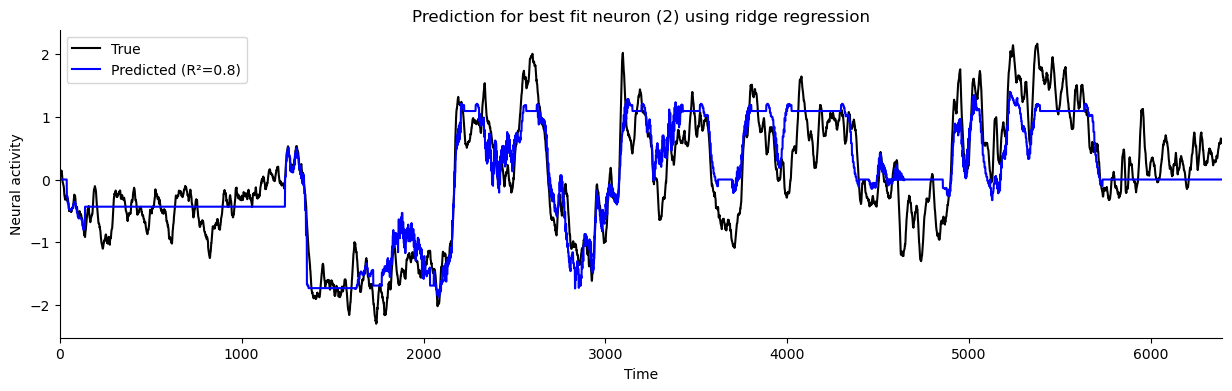

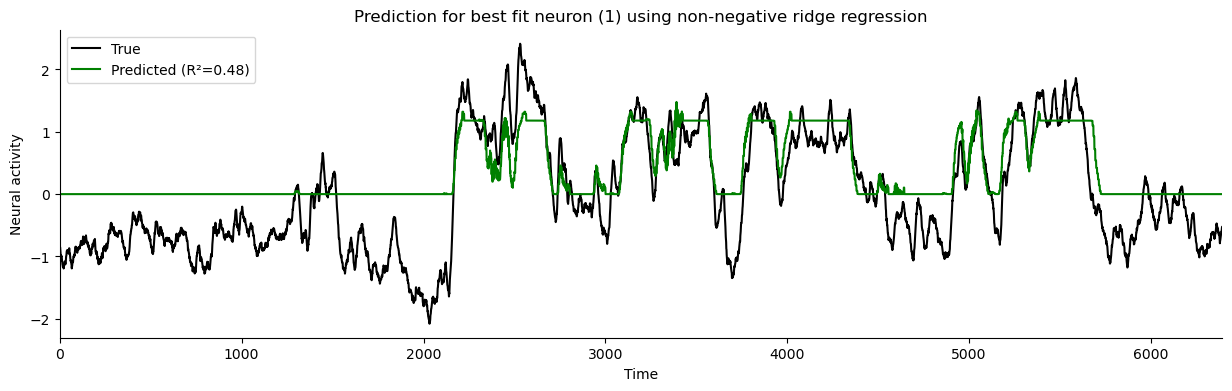

In [118]:
# Plot model prediction vs actual data for the best fit neuron from OLS
fig, ax = plot_model_prediction(betas_lin, x, y, best_fit_neuronidx_lin, r2_lin, color='r')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_lin+1}) using OLS')

# Plot model prediction vs actual data for the best fit neuron from ridge regression
fig, ax = plot_model_prediction(betas_ridge, x, y, best_fit_neuronidx_ridge, r2_ridge, color='b')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_ridge+1}) using ridge regression')

# Plot model prediction vs actual data for the best fit neuron from non-negative ridge regression
fig, ax = plot_model_prediction(betas_nnridge, x, y, best_fit_neuronidx_nnridge, r2_nnridge, color='g')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_nnridge+1}) using non-negative ridge regression')

### Visualize beta weights

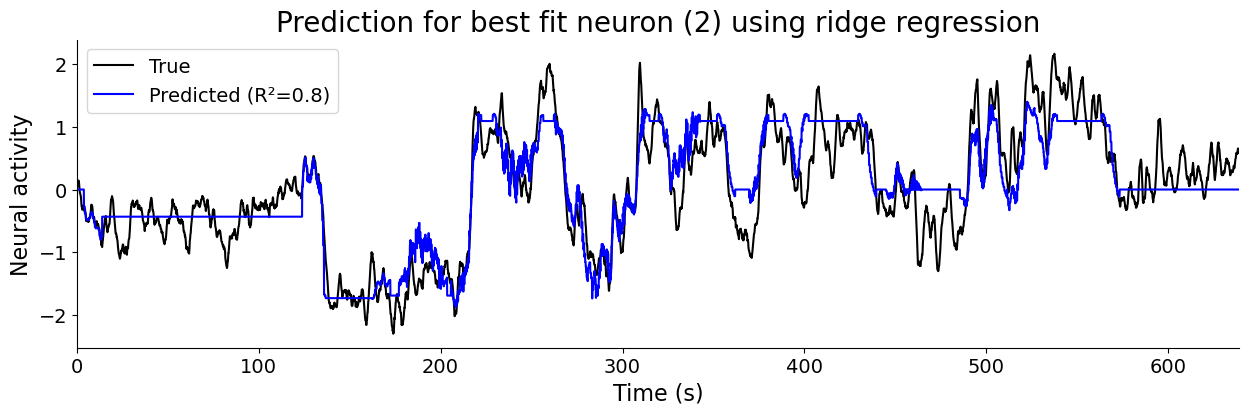

In [119]:
# Plot model prediction vs actual data for the best fit neuron from ridge regression
fig, ax = plot_model_prediction(betas_ridge, x, y, best_fit_neuronidx_ridge, r2_ridge, color='b')
ax.set_title(f'Prediction for best fit neuron ({best_fit_neuronidx_ridge+1}) using ridge regression', fontsize=20)
ax.set_xticks(np.arange(0, y.shape[0], 1000))
ax.set_xticklabels(np.arange(0, y.shape[0], 1000) // frame_rate, fontsize=14)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='y', labelsize=14)
ax.set_ylabel('Neural activity', fontsize=16)
ax.legend(fontsize=14)

plt.savefig(f'figures/20231202/GLMMixedPrediction{mouse}.svg')

In [120]:
# Average betas across regressors for each behavior
betas_ridge_input_averaged = np.mean(betas_ridge_reshaped, axis=2)

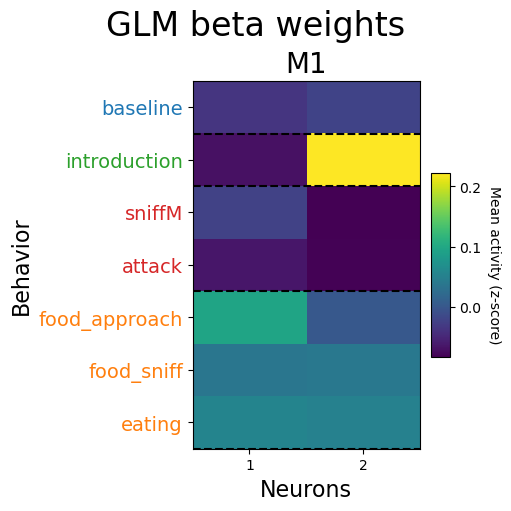

In [121]:
# Plot tuning raster
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

# Determine the color scale based on the min and max of both datasets
vmin = betas_ridge_input_averaged.min()
vmax = betas_ridge_input_averaged.max()
divnorm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the tuning raster
im = ax.imshow(betas_ridge_input_averaged.T, cmap='viridis', aspect='auto', interpolation='none', vmin=vmin, vmax=vmax)
if mouse == 'M1':
    ax.set_title('M1', fontsize=20)
elif mouse == 'M2':
    ax.set_title('M2', fontsize=20)
ax.set_xticks([0, betas_ridge_input_averaged.shape[0]-1])
ax.set_xticklabels([1, betas_ridge_input_averaged.shape[0]])
ax.set_xlabel('Neurons', fontsize=16)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels, fontsize=14)
ax.set_ylabel('Behavior', fontsize=16)

# Color the yticklabels
ytickcolors = ['tab:blue',
                'tab:green',
                'tab:red', 'tab:red',
                'tab:orange', 'tab:orange', 'tab:orange']

# Get the yticklabels and set their color
for i, yticklabel in enumerate(ax.get_yticklabels()):
    yticklabel.set_color(ytickcolors[i % len(ytickcolors)])

# Separate behaviors
group_indices = [1, 2, 4, 7] # Indices of the first behavior in each group
for b in group_indices:
    ax.axhline(y=b-1/2, color='black', linestyle='--')

# Add a colarbar
cbar = fig.colorbar(im, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Mean activity (z-score)', rotation=-90, va="bottom")

plt.suptitle('GLM beta weights', fontsize=24)
plt.savefig(f'figures/20231202/GLMRidgeWeights{mouse}.svg')

## EDA

### Cluster beta weights

In [48]:
# Generate range of number of clusters to evaluate
range_n_clusters = np.arange(2, 10)

#### Dimensionality reduction of ridge betas using PCA

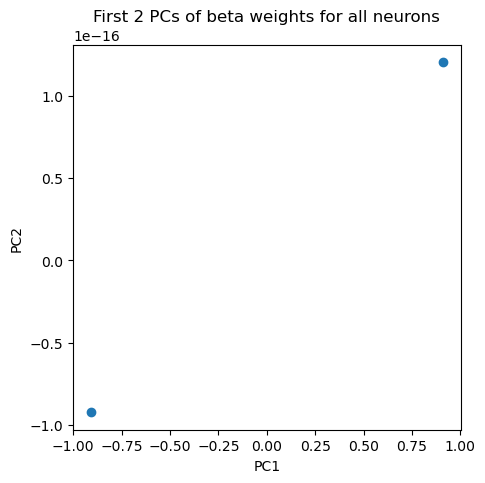

In [49]:
# Perform PCA on the beta weights
pca = PCA(n_components=2)
pca.fit(betas_ridge)
betas_ridge_pca = pca.transform(betas_ridge)

# Plot the beta weights in the PCA space
fig, ax = plt.subplots(figsize=(5, 5))
scatter = ax.scatter(betas_ridge_pca[:, 0], betas_ridge_pca[:, 1])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('First 2 PCs of beta weights for all neurons')
plt.show()

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: Number of labels is 2. Valid values are 2 to n_samples - 1 (inclusive)

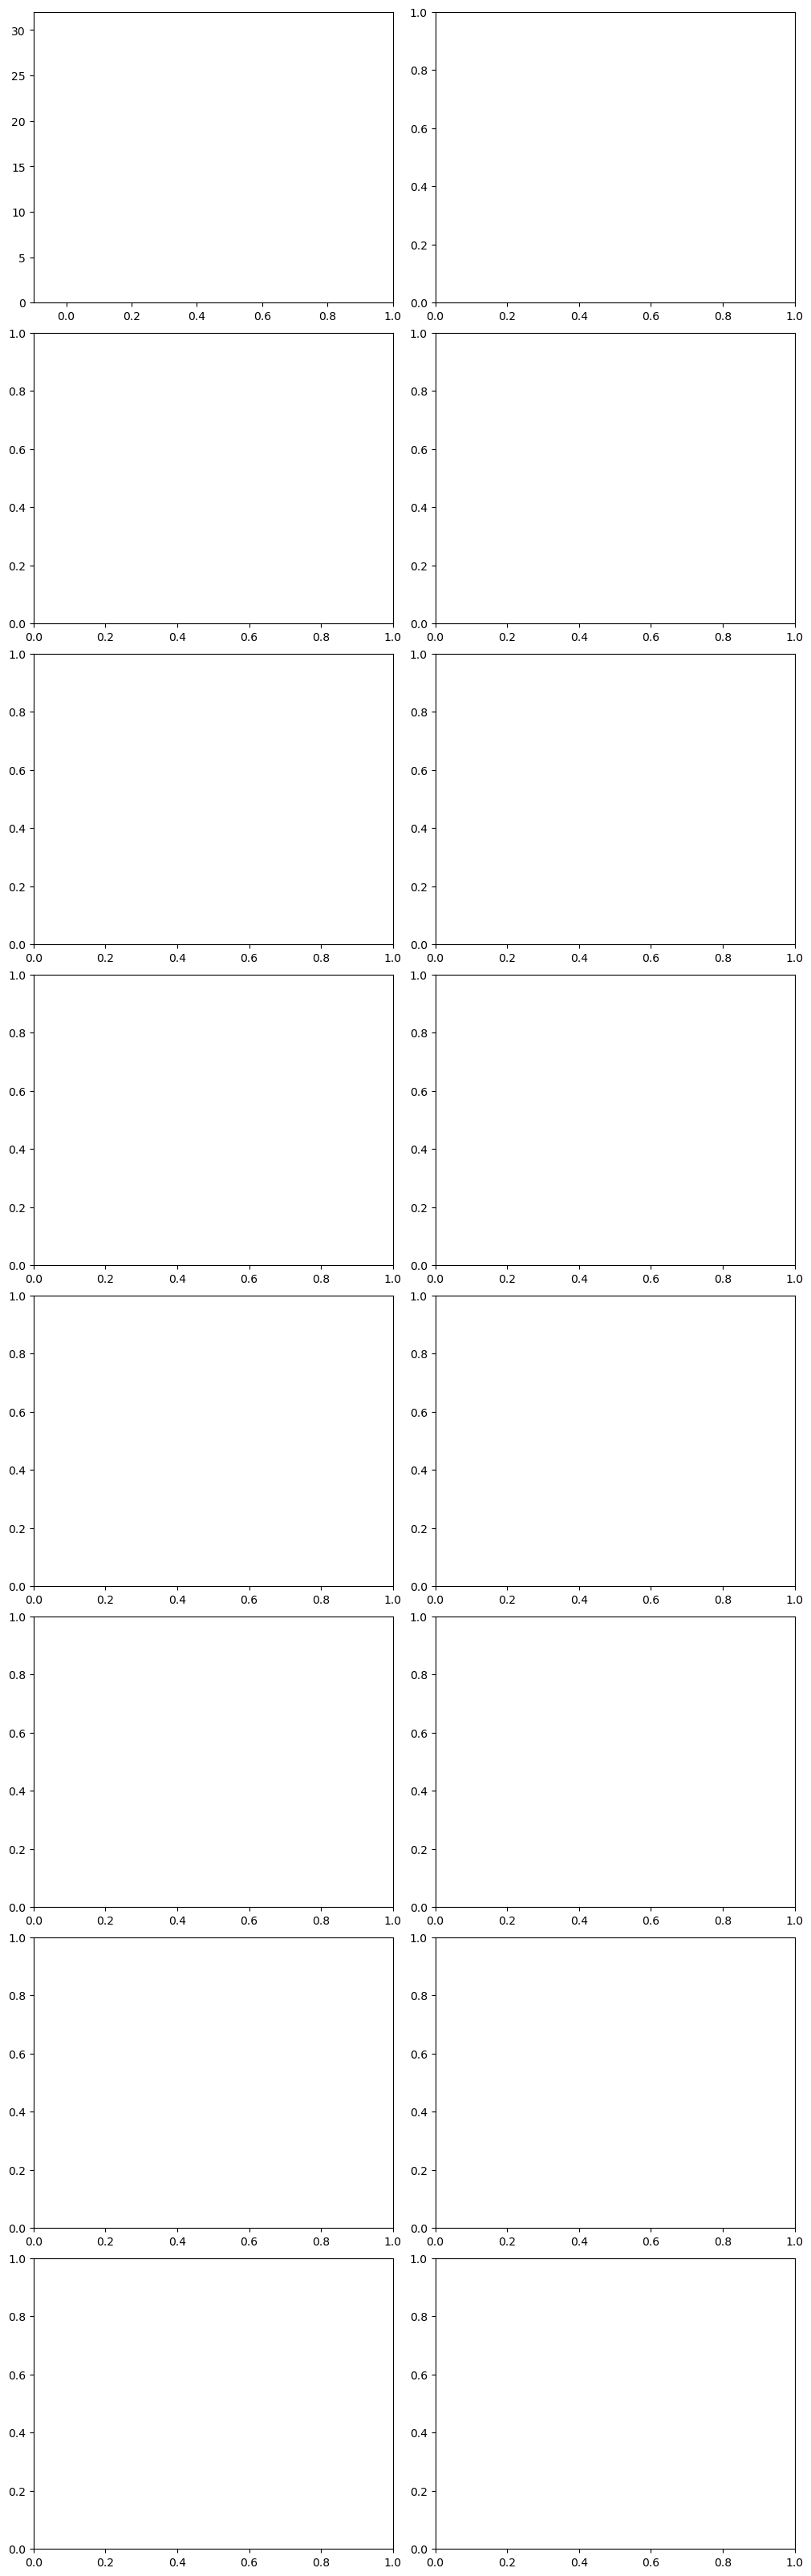

In [50]:
# Cluster beta weights in PCA space
fig, axs, best_n_clusters_pca = plot_kmeans_silhouette(range_n_clusters, betas_ridge_pca)

#### Average ridge betas across regressors for input variable

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 2 the average silhouette_score is : 0.22250892260327723
For n_clusters = 3 the average silhouette_score is : 0.17039635891348354
For n_clusters = 4 the average silhouette_score is : 0.1927557556751834
For n_clusters = 5 the average silhouette_score is : 0.18435614807422376
For n_clusters = 6 the average silhouette_score is : 0.16858405998376155


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 the average silhouette_score is : 0.1888058488587407
For n_clusters = 8 the average silhouette_score is : 0.14488536641798216
For n_clusters = 9 the average silhouette_score is : 0.16358742483833932
The number of clusters that maximizes silhouette score is:  2


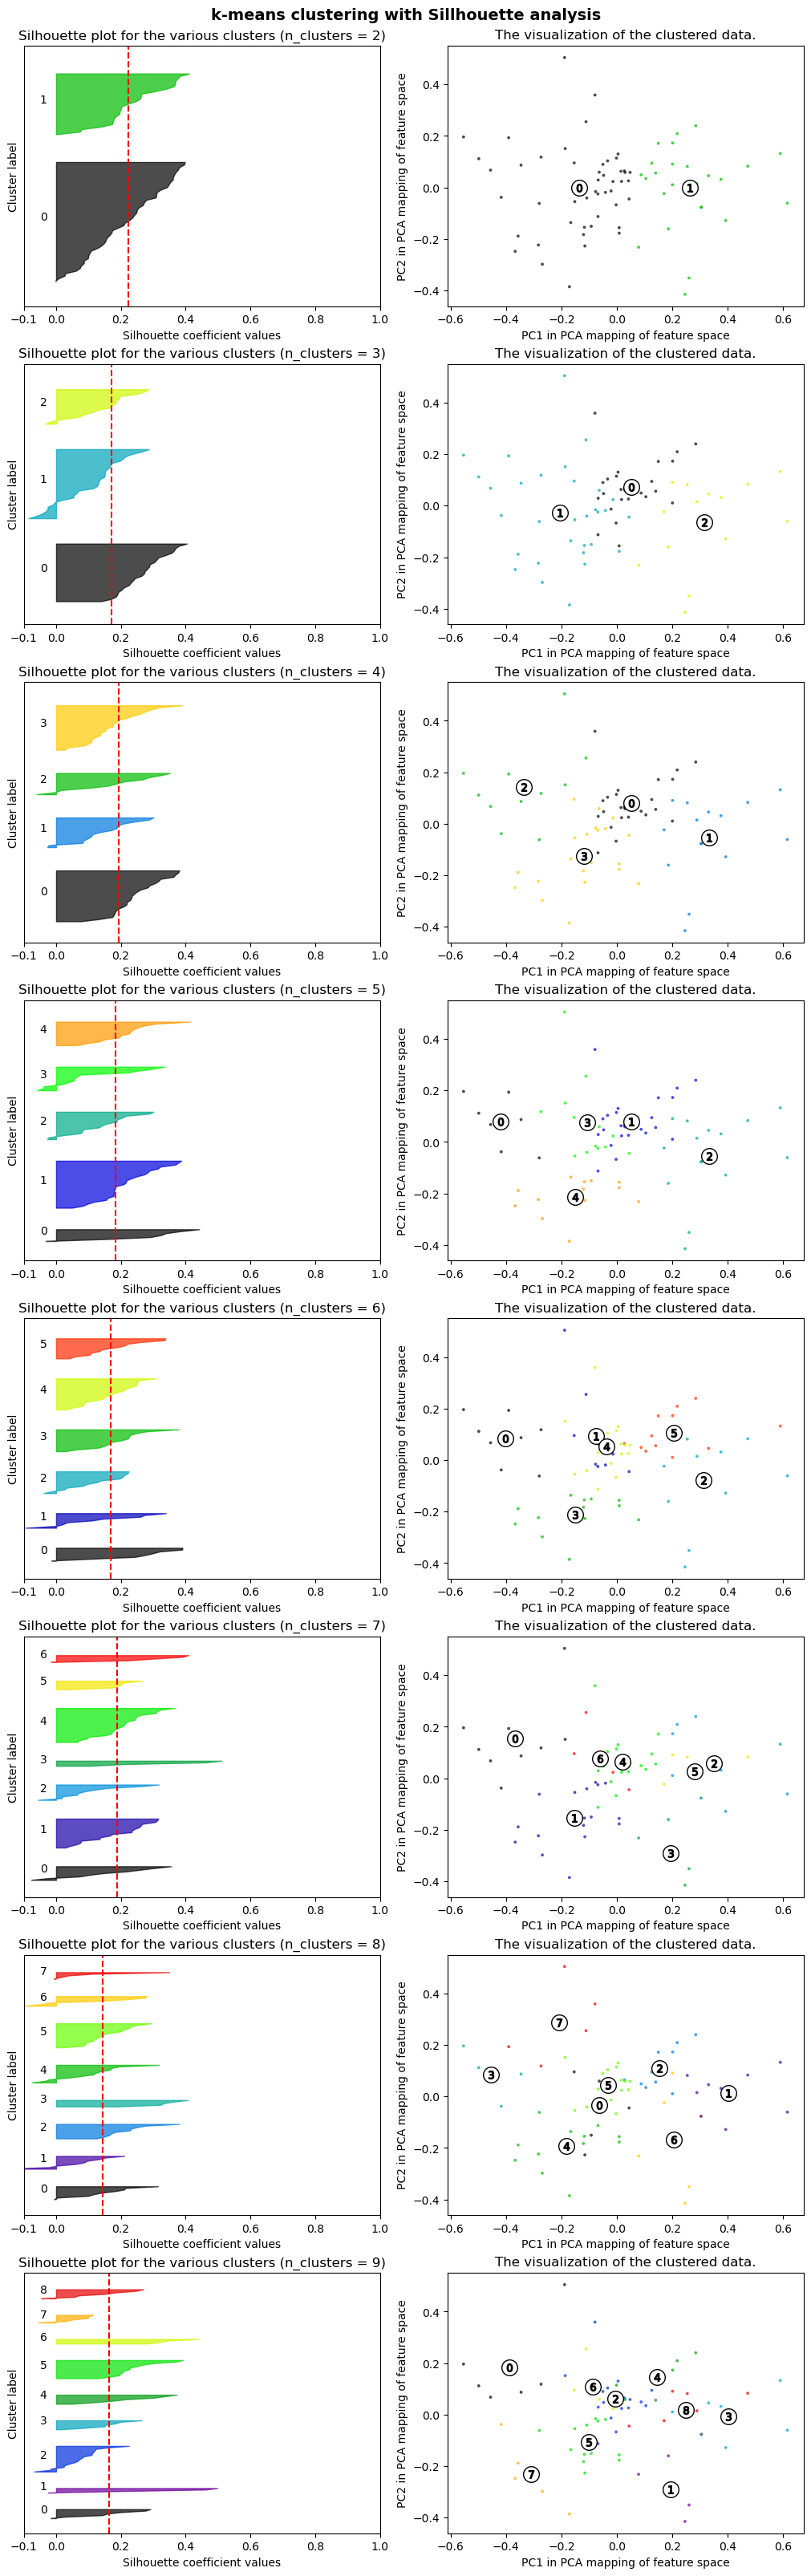

In [ ]:
# Average betas across regressors for each behavior
betas_ridge_input_averaged = np.mean(betas_ridge_reshaped, axis=2)

# Cluster beta weights after averaging across regressors
fig, axs, best_n_clusters_ridge = plot_kmeans_silhouette(range_n_clusters, betas_ridge_input_averaged)

#### Average non-negative ridge betas

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ValueError: Number of labels is 2. Valid values are 2 to n_samples - 1 (inclusive)

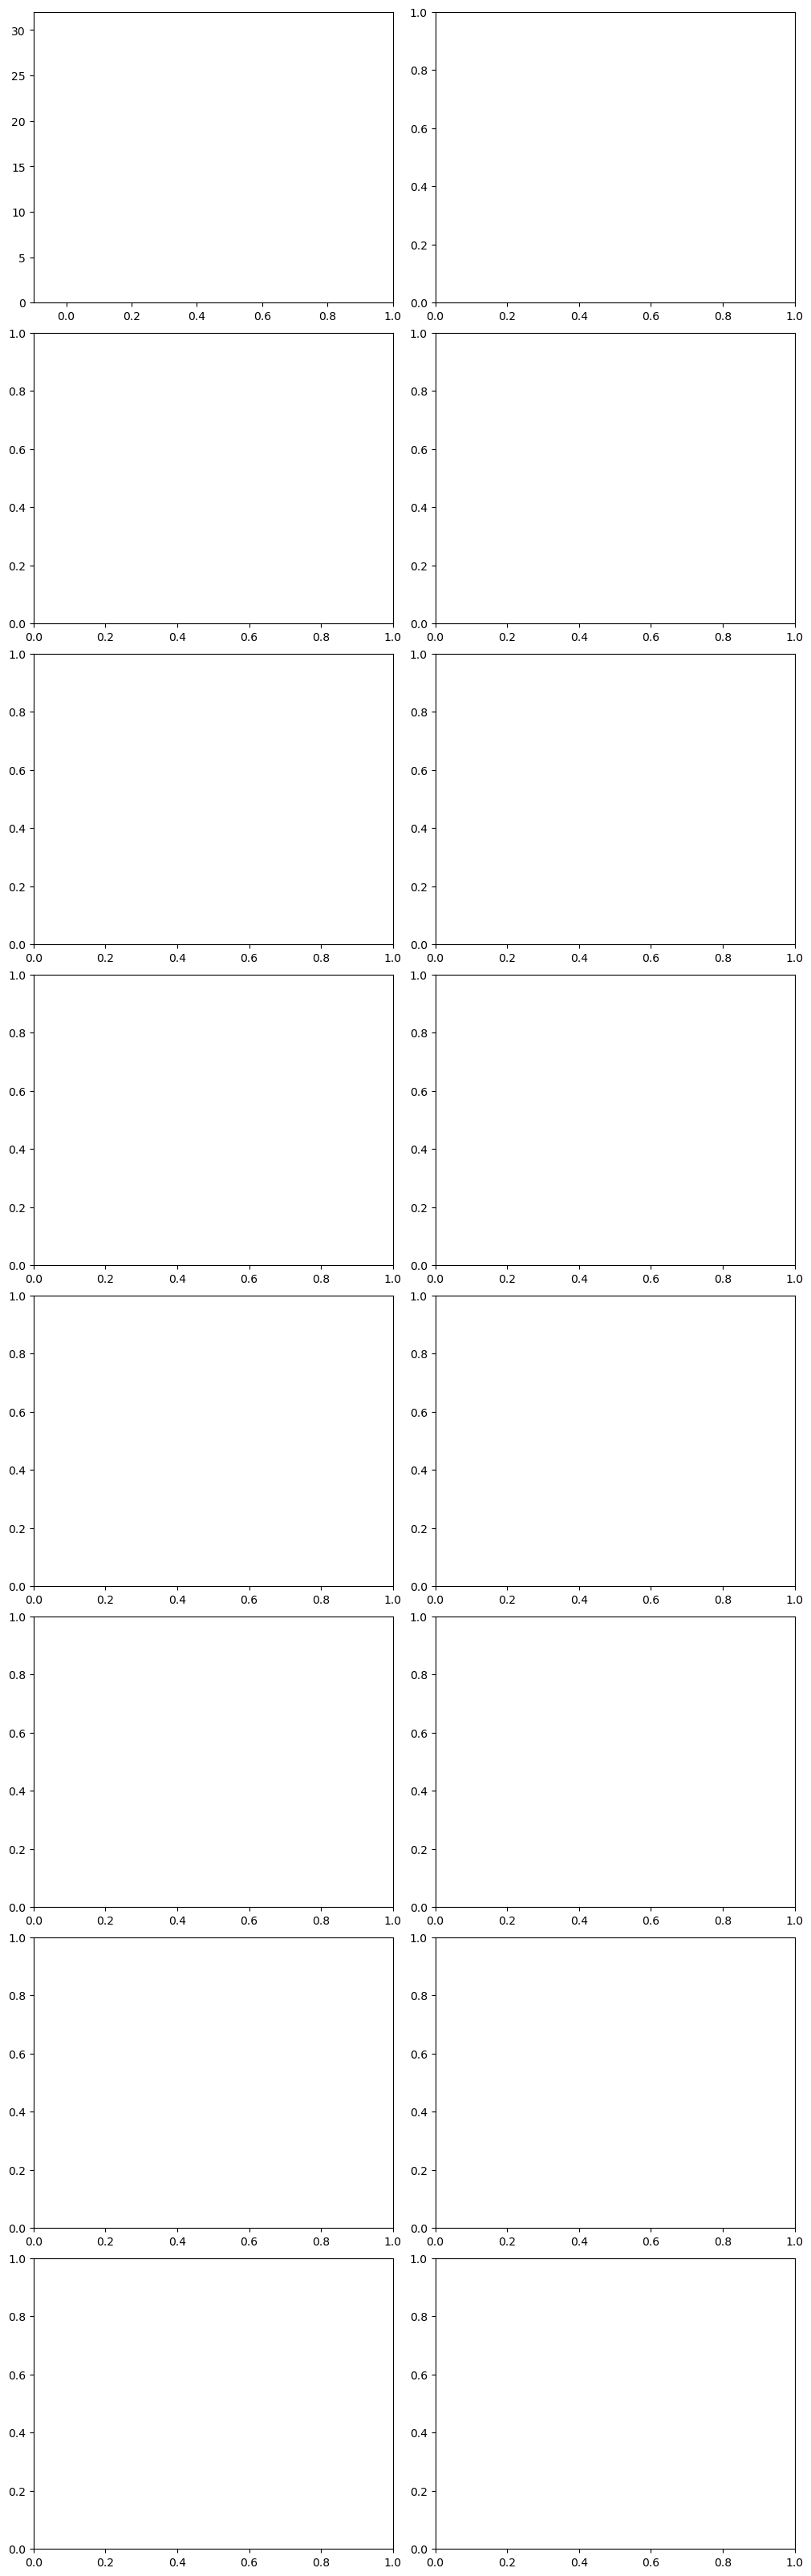

In [51]:
# Average betas across regressors for each behavior
betas_nnridge_input_averaged = np.mean(betas_nnridge_reshaped, axis=2)

# Cluster beta weights after averaging across regressors
fig, axs, best_n_clusters_nnridge = plot_kmeans_silhouette(range_n_clusters, betas_nnridge_input_averaged)

### Determine tuning profile of neuron clusters based on beta weights

#### Tuning profile for all neurons

In [52]:
# Plot tuning of beta weights for all neurons
n_clusters = 7
# n_clusters = best_n_clusters_ridge
fig, ax = plot_tuning_beta(n_clusters, betas_ridge_input_averaged) # Ridge regression
ax.set_title(f'Tuning of beta weights for all neurons using ridge regression (n_clusters = {n_clusters})')

# n_clusters = best_n_clusters_nnridge
fig, ax = plot_tuning_beta(n_clusters, betas_nnridge_input_averaged) # Non-negative ridge regression
ax.set_title(f'Tuning of beta weights for all neurons using non-negative ridge regression (n_clusters = {n_clusters})')

NameError: name 'betas_ridge_input_averaged' is not defined

#### Tuning profile for good fit neurons

/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 2 the average silhouette_score is : 0.2516213136862315
For n_clusters = 3 the average silhouette_score is : 0.22000617771490788
For n_clusters = 4 the average silhouette_score is : 0.2062613840652952
For n_clusters = 5 the average silhouette_score is : 0.19079553300922067
For n_clusters = 6 the average silhouette_score is : 0.17062135870570458


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7 the average silhouette_score is : 0.20035168236880407
For n_clusters = 8 the average silhouette_score is : 0.19691394816914343
For n_clusters = 9 the average silhouette_score is : 0.18005722296588927
The number of clusters that maximizes silhouette score is:  2


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 the average silhouette_score is : 0.2397370456607741
For n_clusters = 3 the average silhouette_score is : 0.22241289490087313
For n_clusters = 4 the average silhouette_score is : 0.19328938726527573
For n_clusters = 5 the average silhouette_score is : 0.20279089154614624
For n_clusters = 6 the average silhouette_score is : 0.21771347037263059


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/

For n_clusters = 7 the average silhouette_score is : 0.1839160476919598
For n_clusters = 8 the average silhouette_score is : 0.17905391144067284
For n_clusters = 9 the average silhouette_score is : 0.21762272168019908
The number of clusters that maximizes silhouette score is:  2


/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/alveus/opt/anaconda3/envs/neuraldynamics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/gw/cs3qh9js60v17f2fdvc7ktjh0000gn/T/ipykernel_62493/146651606.p

Text(0.5, 1.0, 'Tuning of beta weights for good fit neurons using non-negative ridge regression (n_neuron = 26, n_clusters = 6)')

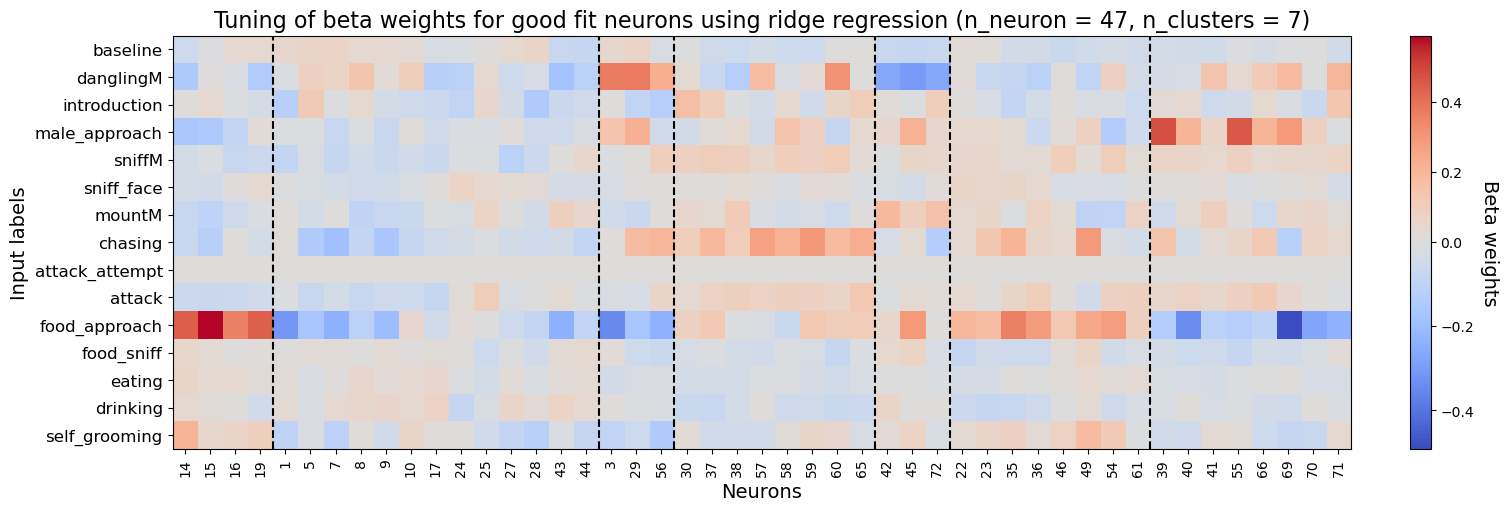

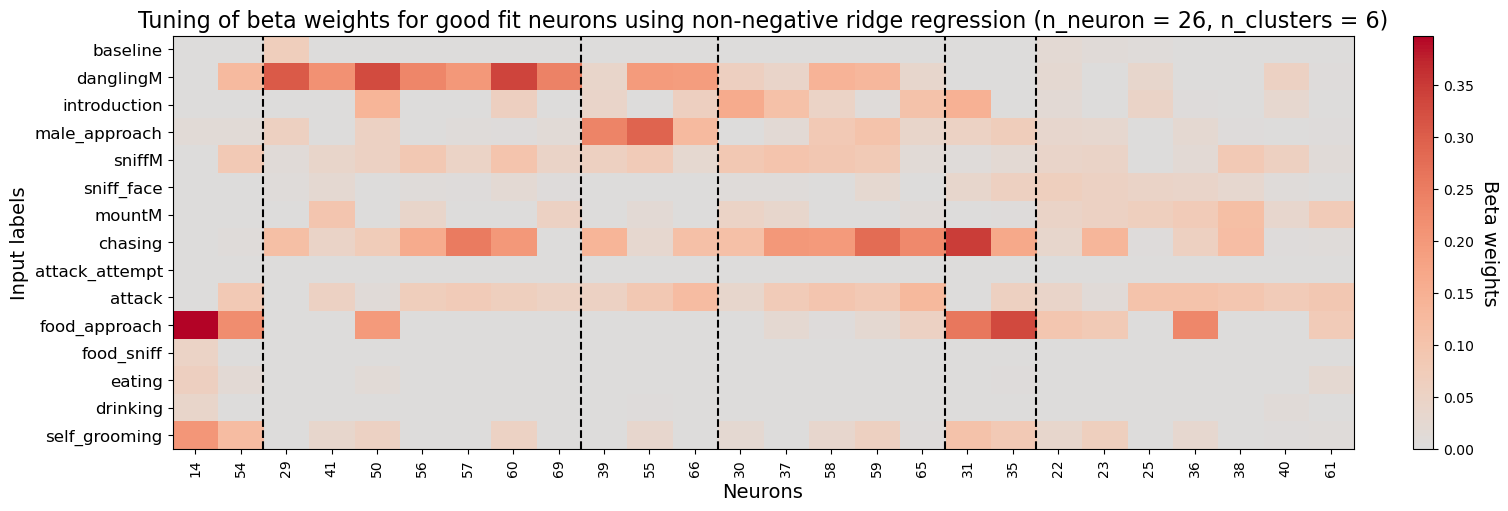

In [111]:
# Plot tuning of beta weights for good fit neurons
fig, axs, best_n_clusters_ridge_goodfit = plot_kmeans_silhouette(range_n_clusters, betas_ridge_input_averaged[good_fit_neuron_ridge, :]) # Determine best number of clusters
plt.close(fig)
n_clusters = 7
# n_clusters = best_n_clusters_ridge_goodfit
fig, ax = plot_tuning_beta(n_clusters, betas_ridge_input_averaged[good_fit_neuron_ridge, :], neuron_idx=good_fit_neuron_ridge) # Ridge regression
ax.set_title(f'Tuning of beta weights for good fit neurons using ridge regression (n_neuron = {len(good_fit_neuron_ridge)}, n_clusters = {n_clusters})', fontsize=16)

fig, axs, best_n_clusters_nnridge_goodfit = plot_kmeans_silhouette(range_n_clusters, betas_nnridge_input_averaged[good_fit_neuron_nnridge, :]) # Determine best number of clusters
plt.close(fig)
n_clusters = 6
# n_clusters = best_n_clusters_nnridge_goodfit
fig, ax = plot_tuning_beta(n_clusters, betas_nnridge_input_averaged[good_fit_neuron_nnridge, :], neuron_idx=good_fit_neuron_nnridge) # Non-negative ridge regression
ax.set_title(f'Tuning of beta weights for good fit neurons using non-negative ridge regression (n_neuron = {len(good_fit_neuron_nnridge)}, n_clusters = {n_clusters})', fontsize=16)

### Visualize neural traces with annotations

In [95]:
# Custom colors for input labels
# custom_colors = np.array([[0.61, 0.18, 0.21, 1.], # attack
#                           [0.61, 0.18, 0.21, 1.], # chase
#                           [0.58, 0.78, 0.93, 1.], # sniffM
#                           [0.93, 0.4, 0.11, 1.], # eating
#                           [0.53, 0.53, 0.53, 1.]]) # food_sniff

# Custom colors for input labels
custom_colors = np.array([[0.61, 0.18, 0.21, 1.], # attack
                        #   [0.61, 0.18, 0.21, 1.], # chase
                          [0.58, 0.78, 0.93, 1.], # sniffM
                        #   [0.93, 0.4, 0.11, 1.], # eating
                          [0.53, 0.53, 0.53, 1.]]) # food_sniff

In [96]:
# EDA on chosen neuron and input labels (OLS)
# neuron_id = 38 # Neuron ID to plot
# labels_to_plot = ['attack', 'attack_attempt', 'danglingM', 'male_approach', 'food_approach'] # Labels to plot
# fig, ax = plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot) # Plot neural activity traces with input labels
# fig, ax = plot_model_prediction(betas_lin, x, y, neuron_id-1, r2_lin) # Plot model prediction vs actual data for the best fit neuron from OLS
# ax.set_title(f'Prediction for neuron {neuron_id} using OLS')
# fig, axs = plot_inputvar_betas(betas_lin_reshaped, neuron_id, labels, time_step, color='r') # Plot betas for each behavior using OLS
# fig.suptitle(f'Beta weights for neuron {neuron_id} using OLS')

In [97]:
labels

['baseline',
 'danglingM',
 'introduction',
 'male_approach',
 'sniffM',
 'sniff_face',
 'mountM',
 'chasing',
 'attack_attempt',
 'attack',
 'food_approach',
 'food_sniff',
 'eating',
 'drinking',
 'self_grooming']

Text(0.5, 0.98, 'Beta weights for neuron 14 using ridge regression')

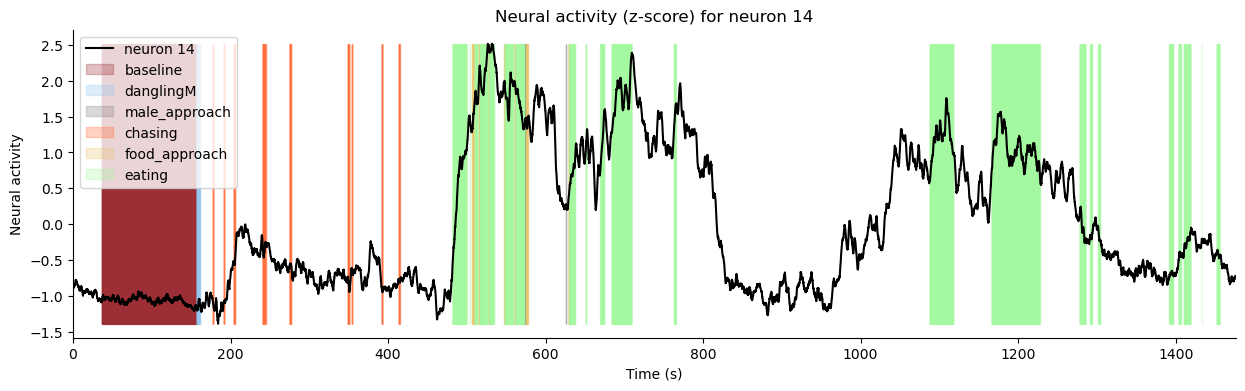

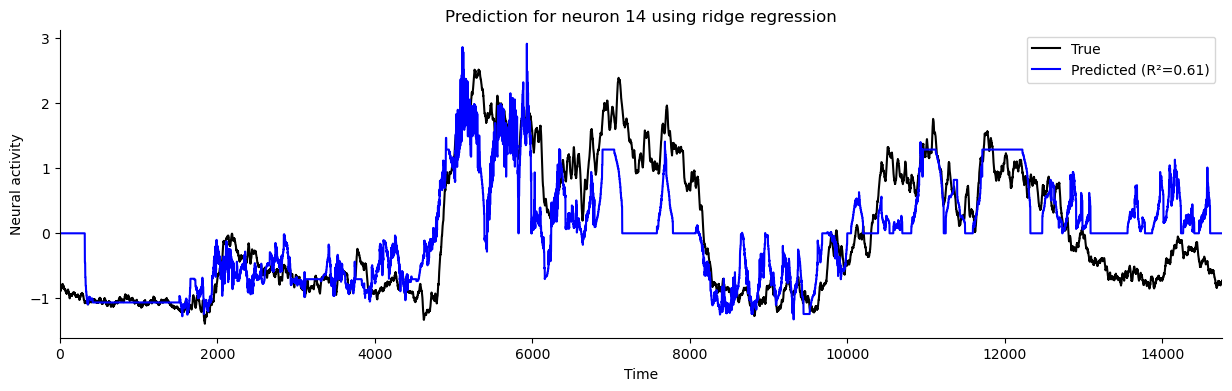

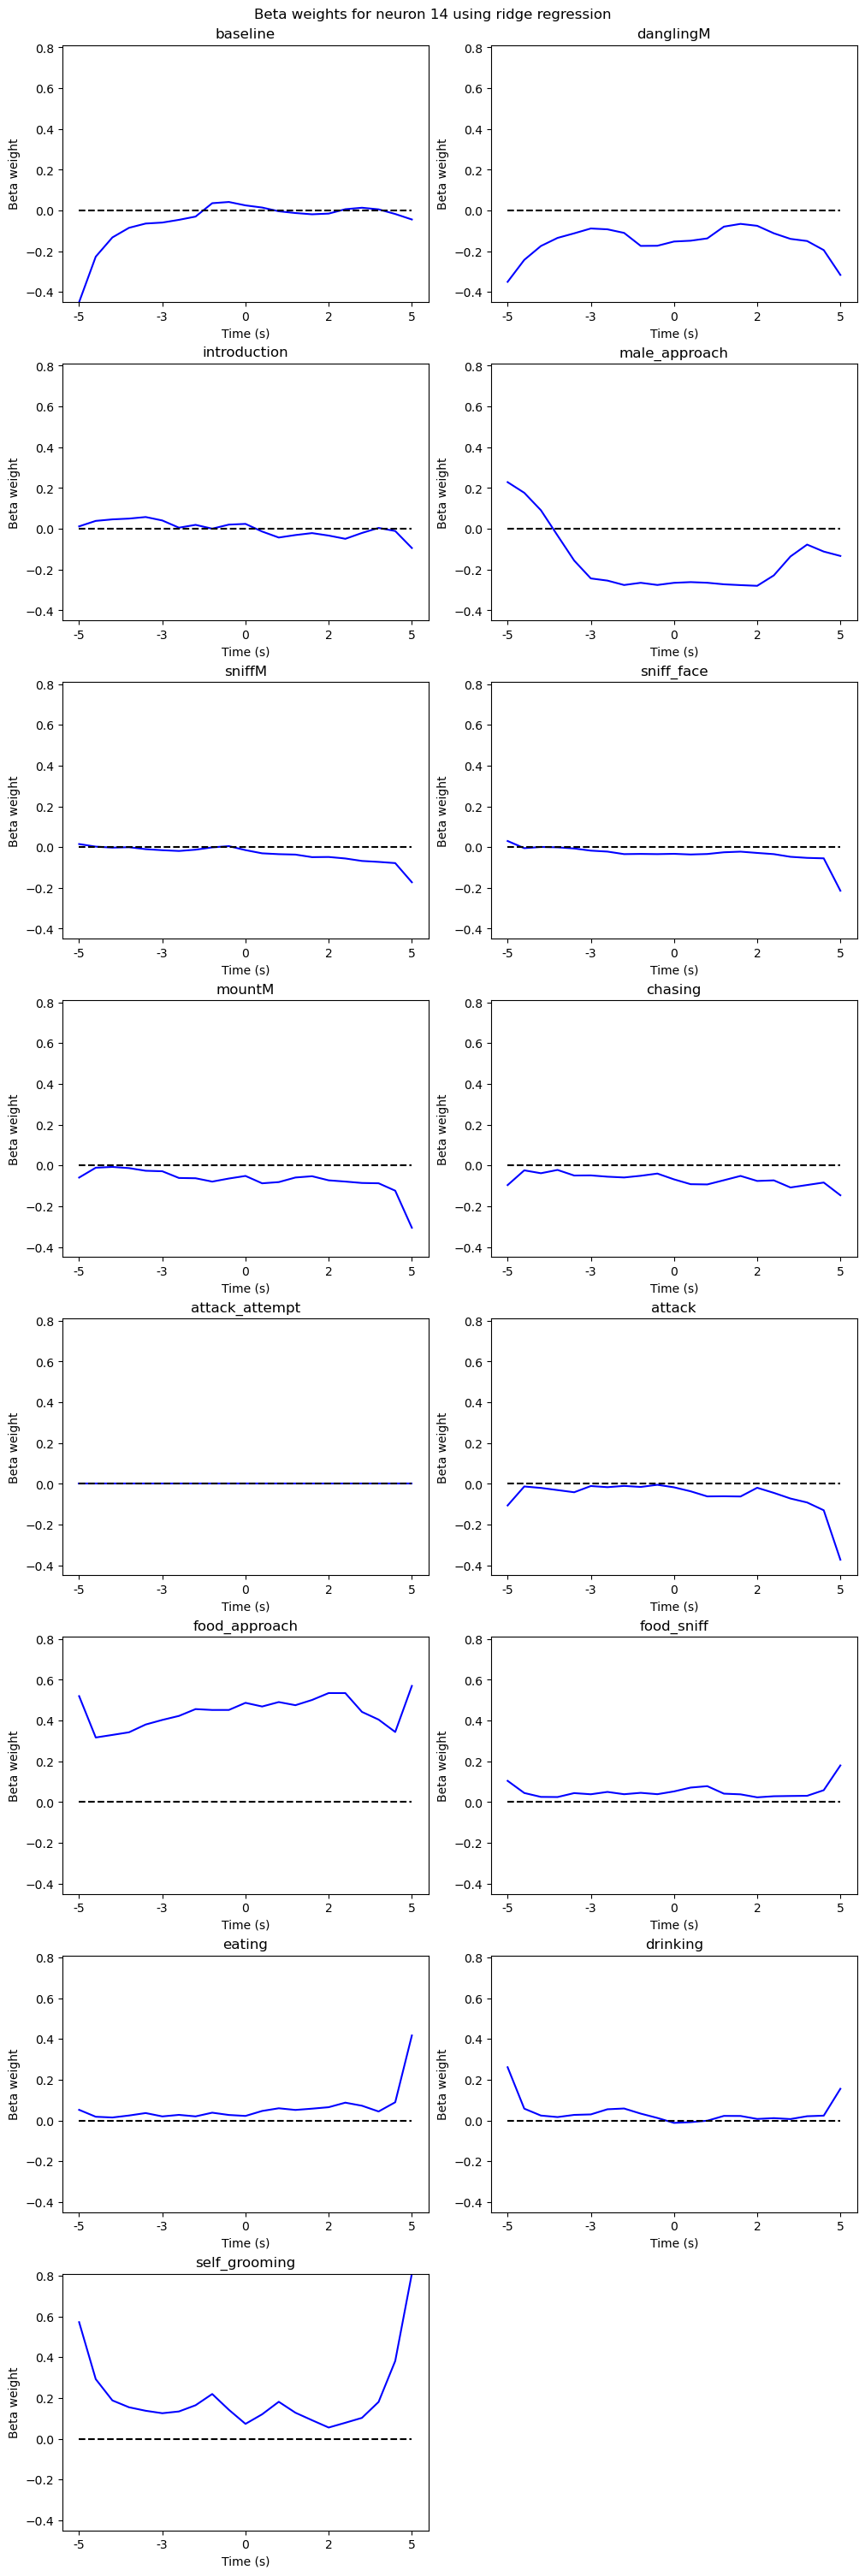

In [98]:
# EDA on chosen neuron and input labels (ridge regression)
neuron_id = 14 # Neuron ID to plot
labels_to_plot = ['baseline', 'danglingM', 'male_approach', 'chasing', 'food_approach', 'eating'] # Labels to plot
# labels_to_plot = ['attack', 'sniffM', 'food_sniff', 'attack_attempt', 'mountM']
fig, ax = plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot, custom_colors) # Plot neural activity traces with input labels
fig, ax = plot_model_prediction(betas_ridge, x, y, neuron_id-1, r2_ridge, color='b') # Plot model prediction vs actual data for the best fit neuron from ridge regression
ax.set_title(f'Prediction for neuron {neuron_id} using ridge regression')
fig, axs = plot_inputvar_betas(betas_ridge_reshaped, neuron_id, labels, time_step, color='b') # Plot betas for each behavior using ridge regression
fig.suptitle(f'Beta weights for neuron {neuron_id} using ridge regression')

Text(0.5, 0.98, 'Beta weights for neuron 14 using ridge regression')

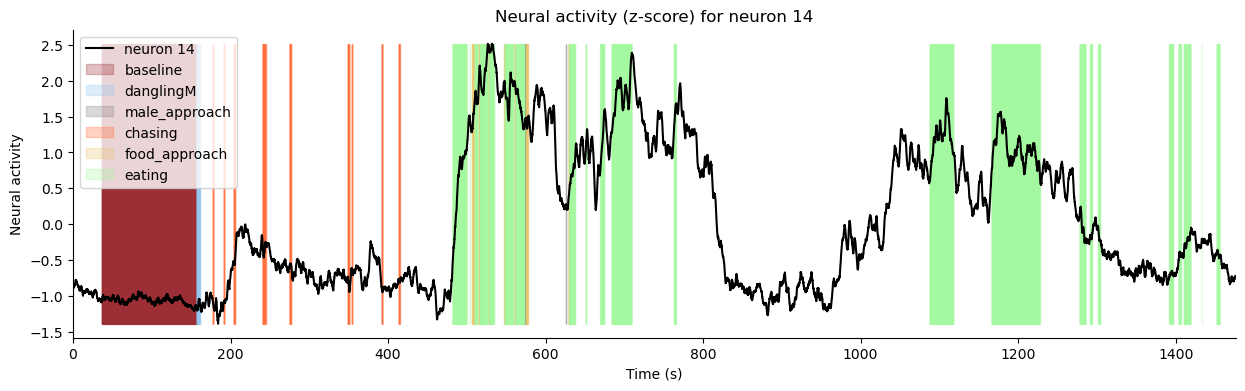

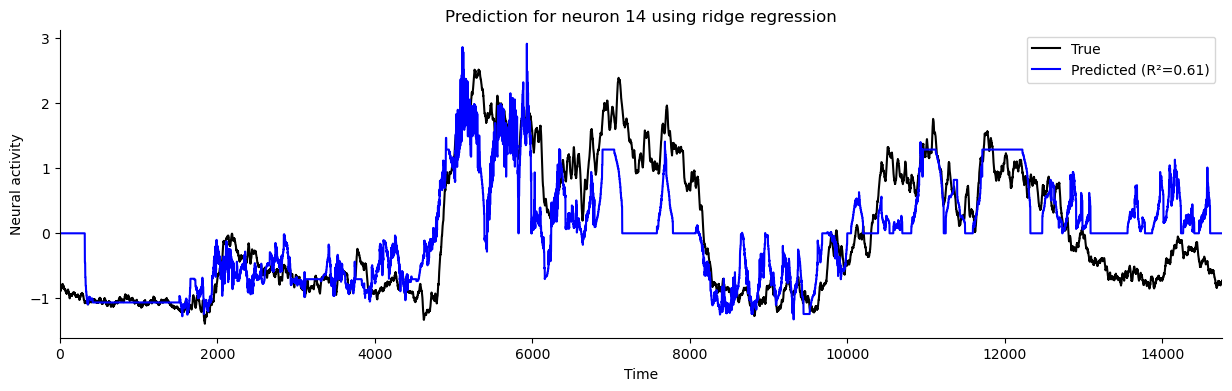

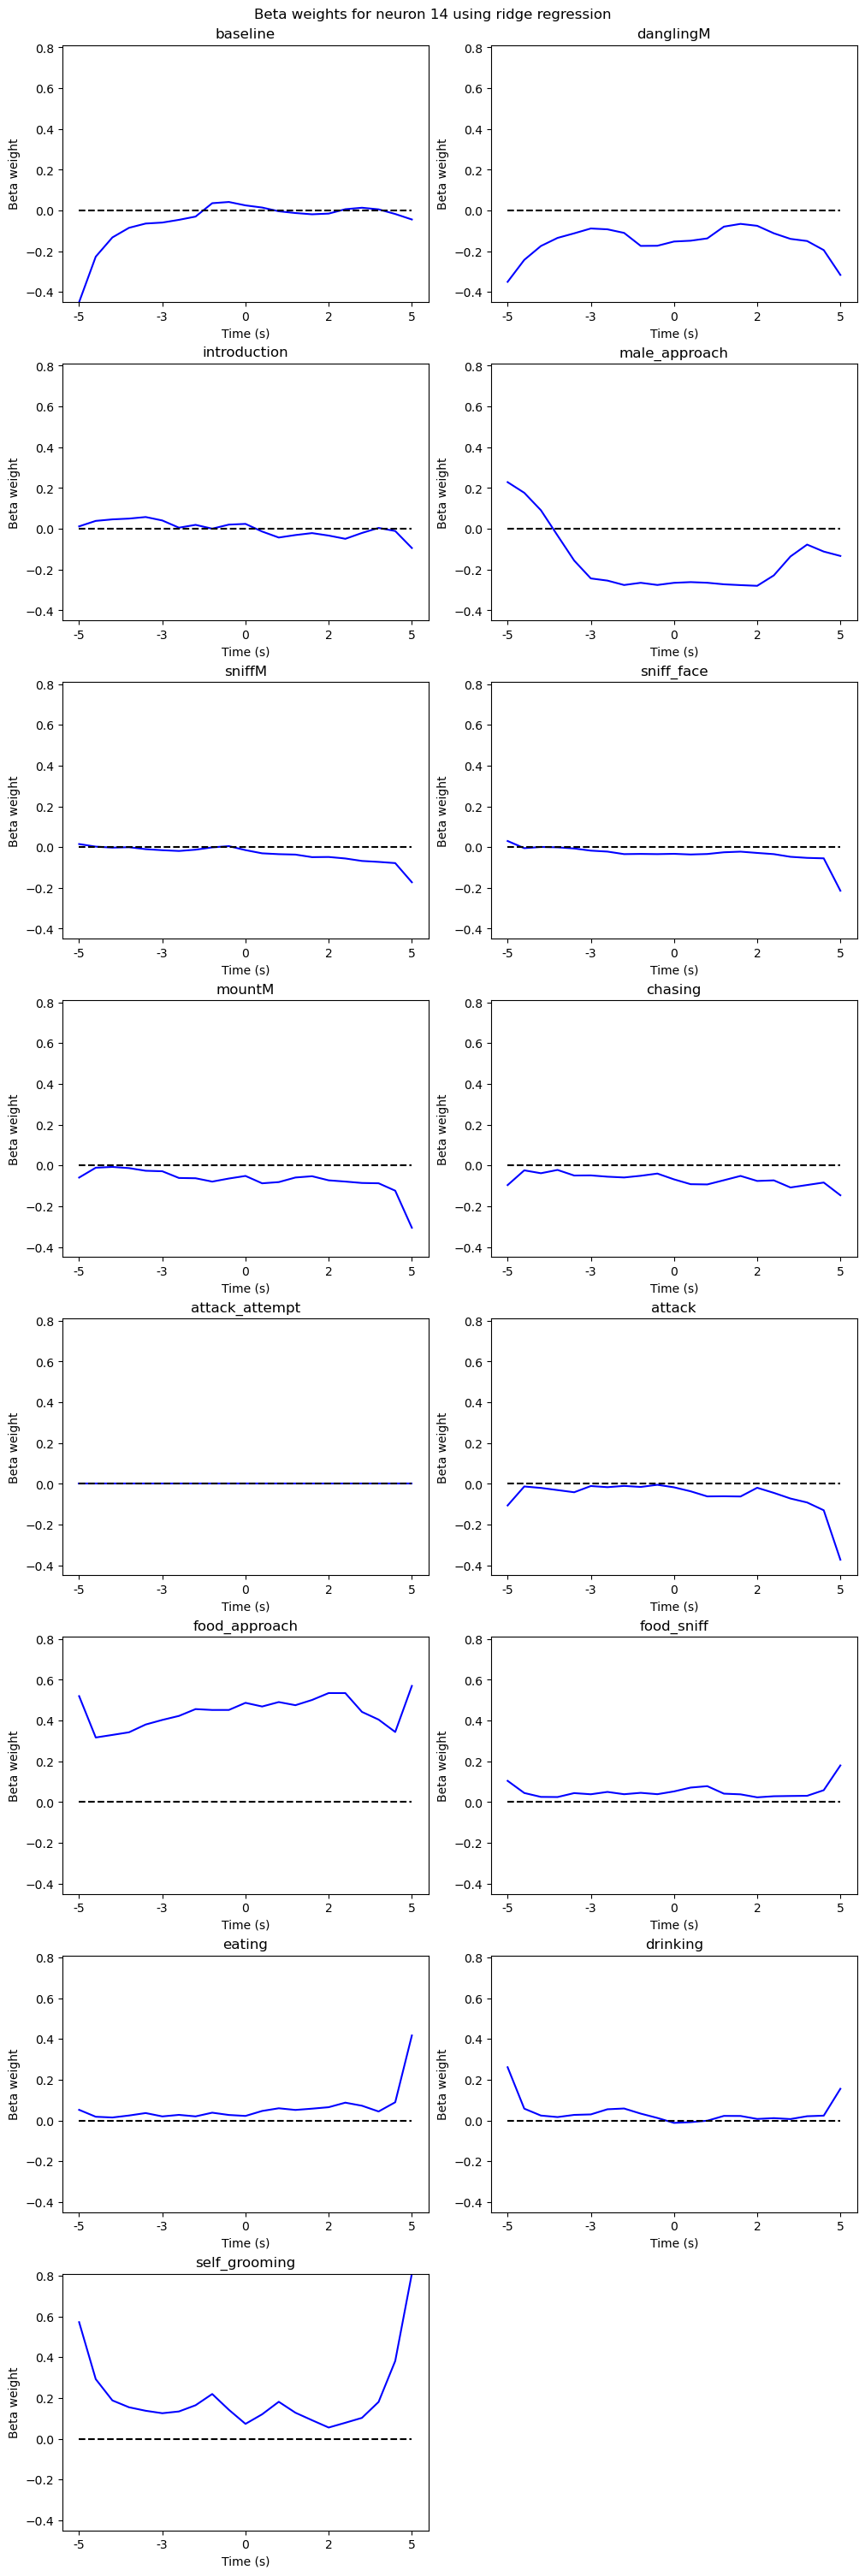

In [99]:
# Some additional plots
neuron_id = 14 # Neuron ID to plot
labels_to_plot = ['baseline', 'danglingM', 'male_approach', 'chasing', 'food_approach', 'eating'] # Labels to plot
# labels_to_plot = ['attack', 'sniffM', 'food_sniff', 'attack_attempt', 'mountM']
fig, ax = plot_trace_with_labels(y, input_labeled, neuron_id, labels_to_plot, custom_colors) # Plot neural activity traces with input labels
fig, ax = plot_model_prediction(betas_ridge, x, y, neuron_id-1, r2_ridge, color='b') # Plot model prediction vs actual data for the best fit neuron from ridge regression
ax.set_title(f'Prediction for neuron {neuron_id} using ridge regression')
fig, axs = plot_inputvar_betas(betas_ridge_reshaped, neuron_id, labels, time_step, color='b') # Plot betas for each behavior using ridge regression
fig.suptitle(f'Beta weights for neuron {neuron_id} using ridge regression')

In [100]:
stimuli_labels

['baseline', 'male', 'object', 'food', 'male2']

In [101]:
stimuli_to_plot = ['baseline', 'male', 'food', 'male2'] # Stimuli labels to plot
np.where(np.isin(stimuli_labels, stimuli_to_plot))[0]

array([0, 1, 3, 4])

In [102]:
stimuli_labels

['baseline', 'male', 'object', 'food', 'male2']

Text(0.5, 0.98, 'Neural activity (z-score) for neuron 70')

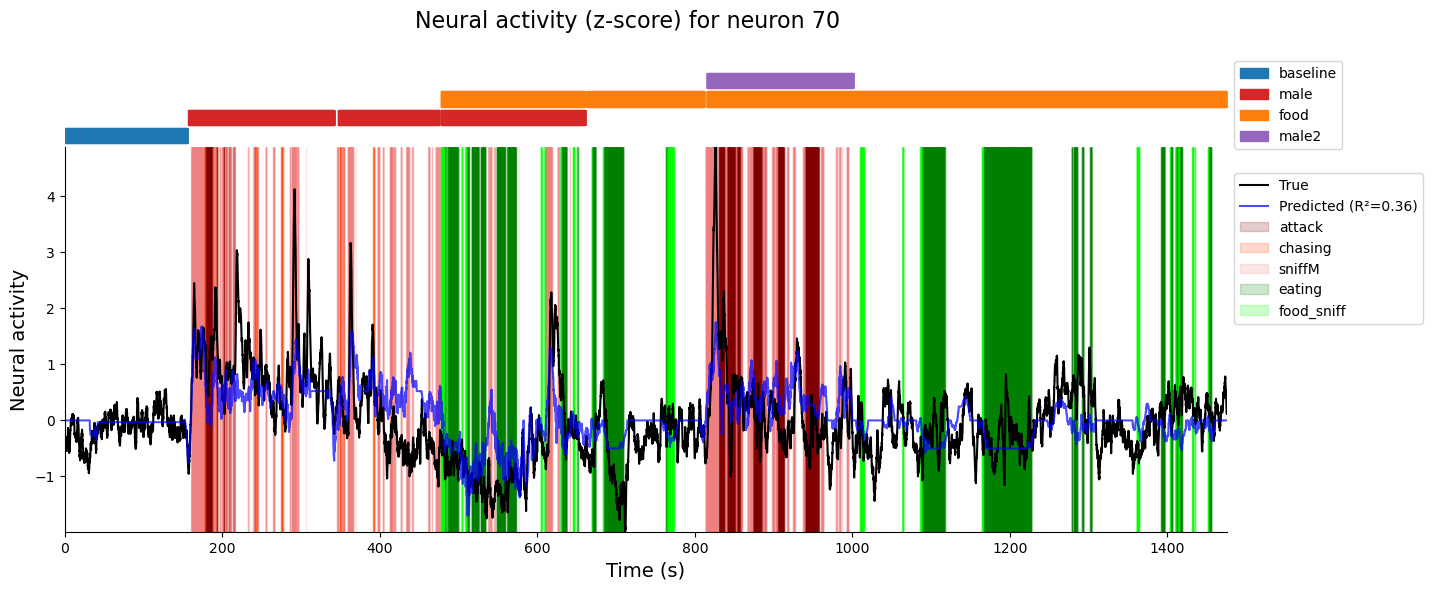

In [112]:
# EDA on chosen neuron and input labels (non-negative ridge regression)
neuron_id = 70 # Neuron ID to plot
neuron_idx = neuron_id - 1
labels_to_plot = ['attack', 'chasing', 'sniffM', 'eating', 'food_sniff'] # Labels to plot
stimuli_to_plot = ['baseline', 'male', 'food', 'male2'] # Stimuli labels to plot

fig, axs = plt.subplots(nrows=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 5]})
fig.subplots_adjust(hspace=0, wspace=0.1)

# Add colored bars for the stimuli in the fed condition
y1 = 0
thickness = 0.05
y2 = y1 + thickness
space = 0.01
bar_colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:orange', 'tab:purple'] # Custom colors for stimuli
handles_display = []
for i in np.where(np.isin(stimuli_labels, stimuli_to_plot))[0]:
    first = True
    # if len(stimuli_labels)!=4 and i==2: continue
    for j in range(tt):
        if stimuli[i, j] and first:
            axs[0].fill_between([j, j+1], y1, y2, color=bar_colors[i], label=stimuli_labels[i])
            handles, _ = axs[0].get_legend_handles_labels()
            handles_display.append(handles[-1])
            first = False
        elif stimuli[i, j]:
            axs[0].fill_between([j, j+1], y1, y2, color=bar_colors[i])
    y1 = y2 + space
    y2 = y1 + thickness
axs[0].set_xlim([0, tt])
axs[0].axis('off')
axs[0].legend(handles_display, stimuli_to_plot, loc='upper left', bbox_to_anchor=(1, 1.2))

# Plot neural activity
axs[1].plot(y[:,neuron_idx], color='k', label='True')
axs[1].set_xticks(np.arange(0, y.shape[0], 2000))
axs[1].set_xticklabels(np.arange(0, y.shape[0], 2000) // frame_rate)

# Plot model prediction
betas = betas_ridge[neuron_idx, :]
y_pred = np.zeros_like(y[:,neuron_idx])
for i in range(x.shape[1]):
    y_pred += betas[i] * x[:,i] # Manually calculate ridge regression prediction
axs[1].plot(y_pred, color='b', alpha=0.7, label=f'Predicted (R\u00b2={round(r2_ridge[neuron_idx], 2)})')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlim([0, y.shape[0]])
axs[1].set_xlabel('Time (s)', fontsize=14)
axs[1].set_ylabel('Neural activity', fontsize=14)

# Plot input labels as colored boxes
label_colors = reds[1:7:2] + greens[1:5:3]
legend_handles, legend_labels = axs[1].get_legend_handles_labels()
handles_display = legend_handles
labels_display = legend_labels
ymin = min(y[:,neuron_idx].min(), y_pred.min())
ymax = max(y[:,neuron_idx].max(), y_pred.max())
for l in range(len(labels_to_plot)):
    label = labels_to_plot[l]
    if np.sum(input_labeled[label]) == 0:
        continue
    first = True
    for i in range(tt):
        if input_labeled[label][i] == 1 and first:
            axs[1].fill_between([i, i+1], ymin, ymax, color=label_colors[l], alpha=0.2, label=label)
            legend_handles, legend_labels = axs[1].get_legend_handles_labels()
            handles_display.append(legend_handles[-1])
            labels_display.append(legend_labels[-1])
            first = False
        if input_labeled[label][i] == 1:
            axs[1].fill_between([i, i+1], ymin, ymax, color=label_colors[l], alpha=0.2, label='_nolegend_')
axs[1].set_ylim([ymin, ymax])
axs[1].legend(handles_display, labels_display, loc='upper left', bbox_to_anchor=(1, 0.95))
fig.suptitle(f'Neural activity (z-score) for neuron {neuron_id}', fontsize=16)

## To-do

- [ ] Add stimuli to design matrix
- [x] 5-sec window
- [x] Good fit neurons w/ thresh on R-squared
- [x] Predicted vs actual
- [ ] Cluster beta w/ k-means
  - [x] Try averaging regressor beta weights for each behavior
  - [ ] Try non-negativity constraint
    - [ ] Use LASSO
      - [ ] potentially modify from non_neg_lasso.m
    - [ ] Use ElasticNet with rho set to 0 (equiv. to ridge)
- [ ] Tuning profile of clusters


## Scratch

In [106]:
# # Function: linear regression using OLS
# def ols(x,y):
#     """
#     x: design matrix
#     y: neural data
#     """
#     betas = np.linalg.inv(x.T @ x) @ x.T @ y # the @ symbol is equivalent to np.matmul()
#     return betas

In [107]:
# # Function: R-squared
# def r_squared(y_true, y_pred):
#     """
#     y_true: true value
#     y_pred: predicted value
#     """
#     r_squared = 1-np.sum((y_true-y_pred)**2)/np.sum((y_true-np.mean(y_true))**2)
#     return r_squared

In [108]:
# Separate betas according to labels
# betas_lin_labeled = {}
# betas_ridge_labeled = {}
# betas_nnridge_labeled = {}
# num_labels = len(labels)

# for i in range(num_labels):
#     betas_lin_labeled[labels[i]] = betas_lin[:, i*xd//num_labels:(i+1)*xd//num_labels]
#     betas_ridge_labeled[labels[i]] = betas_ridge[:, i*xd//num_labels:(i+1)*xd//num_labels]
#     betas_nnridge_labeled[labels[i]] = betas_nnridge[:, i*xd//num_labels:(i+1)*xd//num_labels]

# The resulting `betas_lin_labeled` dictionary will have keys corresponding to the labels in `label`, and values corresponding to the corresponding subset of columns in `xd` divided by the number of labels of columns in beta, from left to right.

In [109]:
# # Fit ridge regression with non-negative constraints using ElasticNet
# nnridgereg = linear_model.ElasticNet(alpha=alphas, l1_ratio=0, fit_intercept=fit_intercept, positive=True) # Initialize Ridge object

# betas_nnridge = np.zeros((yd, xd, n_folds)) # Initialize betas matrix
# r2_nnridge = np.zeros((yd, n_folds)) # Initialize r2 matrix

# for i, (train_index, test_index) in enumerate(kf.split(x)): # Loop through folds
#     x_train, x_test = x[train_index], x[test_index] # Split x into train and test sets
#     y_train, y_test = y[train_index], y[test_index] # Split y into train and test sets

#     nnridgereg.fit(x_train, y_train) # Fit ElasticNet regression model
#     betas_nnridge[:,:,i] = nnridgereg.coef_ # Store betas

#     y_pred = nnridgereg.predict(x_test) # Predict y
#     r2_nnridge[:,i] = r2_score(y_test, y_pred, multioutput='raw_values') # Calculate R2

# betas_nnridge = np.mean(betas_nnridge, axis=2) # Average betas across folds
# r2_nnridge = np.mean(r2_nnridge, axis=1) # Average R2 across folds

In [110]:
# Plot raw trace
# fig, ax = plt.subplots(figsize=(15, 4))
# ax.plot(y[:,18], color='k', label='neuron 19')
# ax.plot(input[0, :], color='r', label='attack')
# ax.plot(input[3, :], color='g', label='eating')
# ax.plot(input[5, :], color='b', label='foodsniff')
# ax.set_xticks(np.arange(0, y.shape[0], 2000))
# ax.set_xticklabels(np.arange(0, y.shape[0], 2000) // frame_rate)
# ax.set_xlabel('Time')
# ax.set_ylabel('Neural activity')
# ax.legend()